In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
# allow max rows to be displayed
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import TimeSeriesSplit, KFold
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline       
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, AdaBoostRegressor, GradientBoostingRegressor
import numpy as np
from cubist import Cubist
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
from hyperopt.pyll import scope
pd.set_option('display.max_rows', 150)
import pickle # for saving and loading models
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose, MSTL
from sklearn.tree import DecisionTreeRegressor

from peshbeen.models import (ml_forecaster, ml_bidirect_forecaster, VARModel, MsHmmRegression, MsHmmVar)
from peshbeen.model_selection import (cross_validate,  mv_cross_validate,
                                      cv_tune, mv_cv_tune, prob_param_forecasts,
                                      tune_ets, tune_sarima, ParametricTimeSeriesSplit,
                                      forward_feature_selection, backward_feature_selection,
                                      mv_forward_feature_selection, mv_backward_feature_selection,
                                      hmm_forward_feature_selection, hmm_backward_feature_selection,
                                      hmm_mv_forward_feature_selection, hmm_mv_backward_feature_selection,
                                      hmm_cross_validate, hmm_mv_cross_validate, cv_lag_tune, 
                                      cv_hmm_lag_tune)
from peshbeen.statplots import (plot_ccf, plot_PACF_ACF)
from peshbeen.stattools import (unit_root_test, cross_autocorrelation,
                                lr_trend_model, forecast_trend, pacf_strength, ccf_strength)
from peshbeen.transformations import (fourier_terms, rolling_quantile,
                        rolling_mean, rolling_std, expanding_mean, expanding_std,
                        expanding_quantile, expanding_ets, box_cox_transform,
                        back_box_cox_transform,undiff_ts, seasonal_diff, invert_seasonal_diff,
                        nzInterval, zeroCumulative, kfold_target_encoder, target_encoder_for_test)
from peshbeen.metrics import (MAPE, MASE, MSE, MAE, RMSE, SMAPE, CFE, CFE_ABS, WMAPE, SRMSE, RMSSE, SMAE)
from peshbeen.prob_forecast import (ml_conformalizer, hmm_conformalizer, ets_conformalizer, bidirect_ts_conformalizer, var_conformalizer, bag_boost_aggr_conformalizer,
                                       bidirect_aggr_conformalizer, ets_aggr_conformalizer, s_arima_aggr_conformalizer,
                                       var_aggr_conformalizer, hmm_var_conformalizer)
from sktime.transformations.series.boxcox import BoxCoxTransformer
sns.set_context("talk")
from statsmodels.tsa.seasonal import STL, MSTL
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# import excel file
occupancy_hrs = pd.read_excel('hr_occupancy_df.xlsx')
occupancy_hrs.set_index('Date', inplace=True)
ward_cols_ = occupancy_hrs.columns[:-1].tolist()
occupancy_hrs.rename(columns={col: "ward_" + str(i) for i, col in enumerate(ward_cols_)}, inplace=True)
ward_cols_ = occupancy_hrs.columns[:-1].tolist()

# assign NA any values below 24
occupancy_hrs[occupancy_hrs <= 24] = np.nan

# ## Add month name and week day
# occupancy_hrs['month'] = occupancy_hrs.index.month_name()
# occupancy_hrs['week_day'] = occupancy_hrs.index.day_name()


In [3]:
ward_cols_

['ward_0', 'ward_1', 'ward_2', 'ward_3', 'ward_4', 'ward_5', 'ward_6']

In [3]:
# import refer_source and followup excel file
refer_source = pd.read_excel('refer_source.xlsx')
followup = pd.read_excel('followup_service.xlsx')
cmht_refer_df = refer_source[["refer_date", "CMHT"]]
cmht_refer_df.rename(columns = {"refer_date": "Date", "CMHT": "cmht_refer"}, inplace=True)
cmht_refer_df.set_index("Date", inplace=True)

cmht_followup_df = followup[["disc_date", "CMHRS"]]
cmht_followup_df.rename(columns = {"disc_date": "Date", "CMHRS": "cmht_followup"}, inplace=True)
cmht_followup_df.set_index("Date", inplace=True)

In [4]:

# convert hourly occupancy to daily occupancy so we can approximate dailly number of patients

occupancy_days = occupancy_hrs.copy()

occupancy_days[["ward_0", "ward_1", "ward_2", "ward_3", "ward_4", "ward_5", "ward_6"]] = (
    (occupancy_hrs[["ward_0", "ward_1", "ward_2", "ward_3", "ward_4", "ward_5", "ward_6"]] / 24)
    .round(0)
)


occupancy_days["total"] = occupancy_days[["ward_0", "ward_1", "ward_2", "ward_3", "ward_4", "ward_5", "ward_6"]].sum(axis=1)
occupancy_days = occupancy_days.merge(cmht_refer_df, left_index=True, right_index=True, how='left', validate='one_to_one')
occupancy_days = occupancy_days.merge(cmht_followup_df, left_index=True, right_index=True, how='left', validate='one_to_one')


holidays = pd.read_excel('holidays_eng.xlsx', index_col='Date')
holidays.index = pd.to_datetime(holidays.index)


In [ ]:
# fig, ax = plt.subplots(2, 3, figsize=(15, 8))
# # for i, ward in enumerate(ward_cols_):
# ward_num = 0
# for j in range(2):
#     for k in range(3):
#         ax[j, k].plot(occupancy_days.index, occupancy_days[f"ward_{ward_num}"], label=f"Ward {ward_num}")
#         ax[j, k].set_title(f"Ward {ward_num} Occupancy")
#         # ax[j, k].legend()
#         ward_num += 1

# plt.tight_layout()
# plt.show()


## Add date features to data

In [5]:
occupancy_days["day_of_week"] = occupancy_days.index.weekday
occupancy_days["day_of_month"] = occupancy_days.index.day
occupancy_days["month"] = occupancy_days.index.month
occupancy_days["week_of_year"] = occupancy_days.index.isocalendar().week
occupancy_days["is_weekend"] = occupancy_days["day_of_week"].isin([5, 6])
occupancy_days["year"] = occupancy_days.index.year
occupancy = occupancy_days.merge(holidays, left_index=True, right_index=True, how='left')
occupancy["holiday"].fillna("not_holiday", inplace=True)
occupancy["is_holiday"] = occupancy["holiday"].apply(lambda x: "holiday" if x != "not_holiday" else"not_holiday")

fourier_term = fourier_terms(start_end_index=[occupancy_days.index.min(), occupancy_days.index.max()], period=365.25, num_terms=2)
occupancy = occupancy.merge(fourier_term, left_index=True, right_index=True, how='left')

In [6]:
# train-test split for both dataset and test size is 30 days for both datasets occupancy_hrs and occupancy_fourier
train_size = len(occupancy) - 360
occup_train = occupancy[:train_size]
occup_test = occupancy[train_size:]

## Analysis on the effect of weekdays, month days etc on occupancy data

## Weekly Occupancy for Each Ward

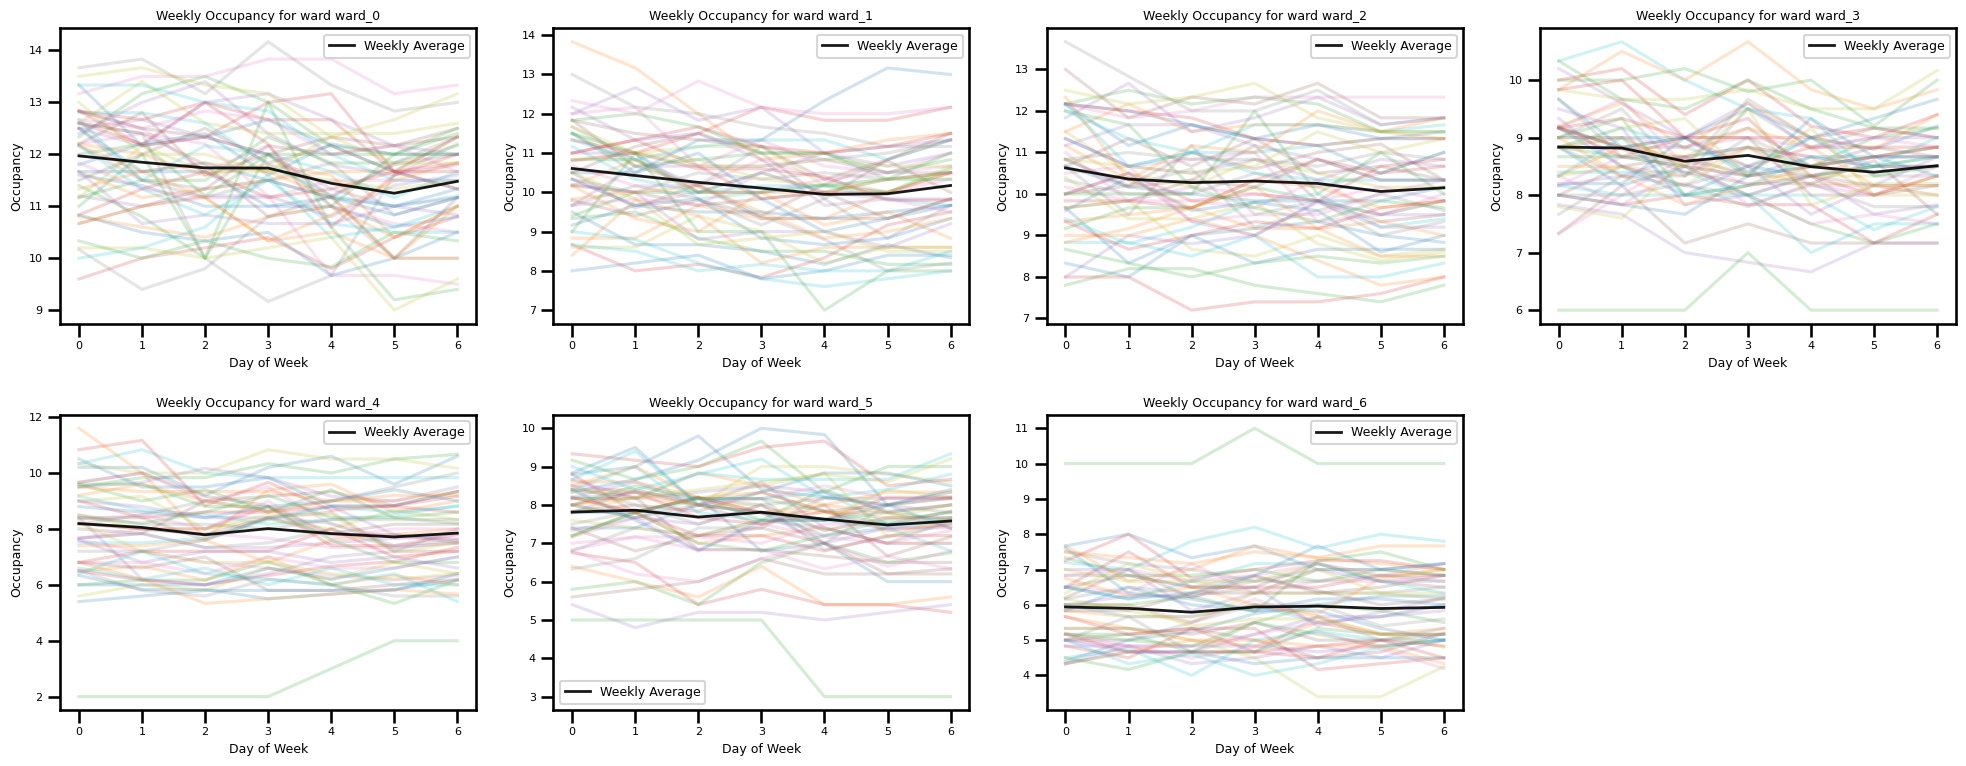

In [10]:
wards = [f"ward_{i}" for i in range(7)]  # e.g. 7 wards (0..6)
n_plots = len(wards)

# create a grid with enough slots (2 rows, 4 cols = 8 slots here)
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()  # flatten to index linearly

for ax, ward_col in zip(axes[:n_plots], wards):
        # Plot each week's data (less transparent)
        ward = occup_train.pivot_table(index="day_of_week", columns="week_of_year", values=ward_col, aggfunc='mean').reset_index()
        mean = occup_train.groupby('day_of_week')[ward_col].mean()
        for week in ward.columns[1:]:
            ax.plot(ward.index, ward[week], alpha=0.2)  # Less transparent

        # Plot average of all weeks (more transparent, thicker line)
        ax.plot(mean.index, mean, color='black', linewidth=2, alpha=0.9, label='Weekly Average')  # More transparent
        ax.set_xlabel("Day of Week", fontsize=9)
        ax.tick_params(axis='both', labelsize=8)  # <-- Correct way
        ax.set_ylabel("Occupancy", fontsize=9)
        ax.set_title(f"Weekly Occupancy for ward {ward_col}", fontsize=9)
        ax.legend(fontsize = 9)  # <-- Only 'Weekly Average' will show up

# remove any unused axes (if grid has more slots than n_plots)
for ax in axes[n_plots:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

## Occupancy by day of month for each month

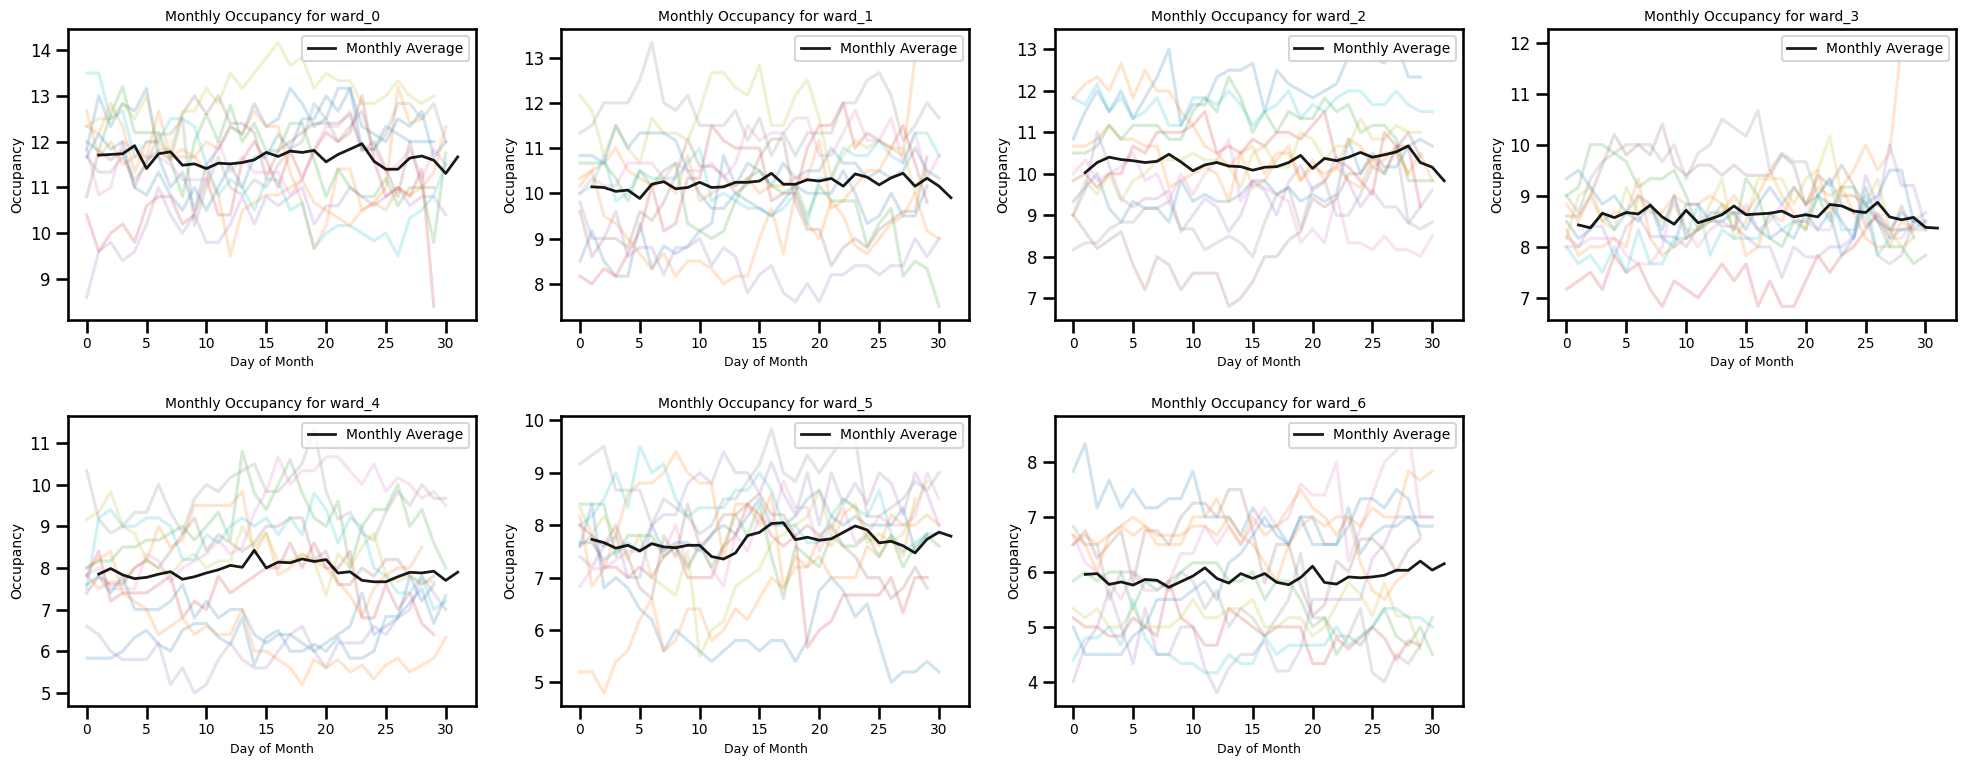

In [14]:
year_df = occup_train[occup_train["year"].isin([2019, 2020, 2021, 2022, 2023])]

# choose how many wards to plot
wards = [f"ward_{i}" for i in range(7)]  # e.g. 7 wards (0..6)
n_plots = len(wards)

# create a grid with enough slots (2 rows, 4 cols = 8 slots here)
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()  # flatten to index linearly

for ax, ward_col in zip(axes[:n_plots], wards):
        # Plot each week's data (less transparent)
        ward = occup_train.pivot_table(index="day_of_month", columns="month", values=ward_col, aggfunc='mean').reset_index()
        mean = occup_train.groupby('day_of_month')[ward_col].mean()
        for week in ward.columns[1:]:
            ax.plot(ward.index, ward[week], alpha=0.2)  # Less transparent

        # Plot average of all weeks (more transparent, thicker line)
        ax.plot(mean.index, mean, color='black', linewidth=2, alpha=0.9, label='Monthly Average')  # More transparent
        ax.set_xlabel("Day of Month", fontsize=9)
        ax.tick_params(axis='both', labelsize=9)  # <-- Correct way
        ax.tick_params(axis='x', labelsize=10)  # x-axis tick labels size
        ax.tick_params(axis='y', labelsize=12) # y-axis tick labels size
        ax.set_ylabel("Occupancy", fontsize=10)
        ax.set_title(f"Monthly Occupancy for {ward_col}", fontsize=10)
        ax.legend(loc='upper right', fontsize=10)

# remove any unused axes (if grid has more slots than n_plots)
for ax in axes[n_plots:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

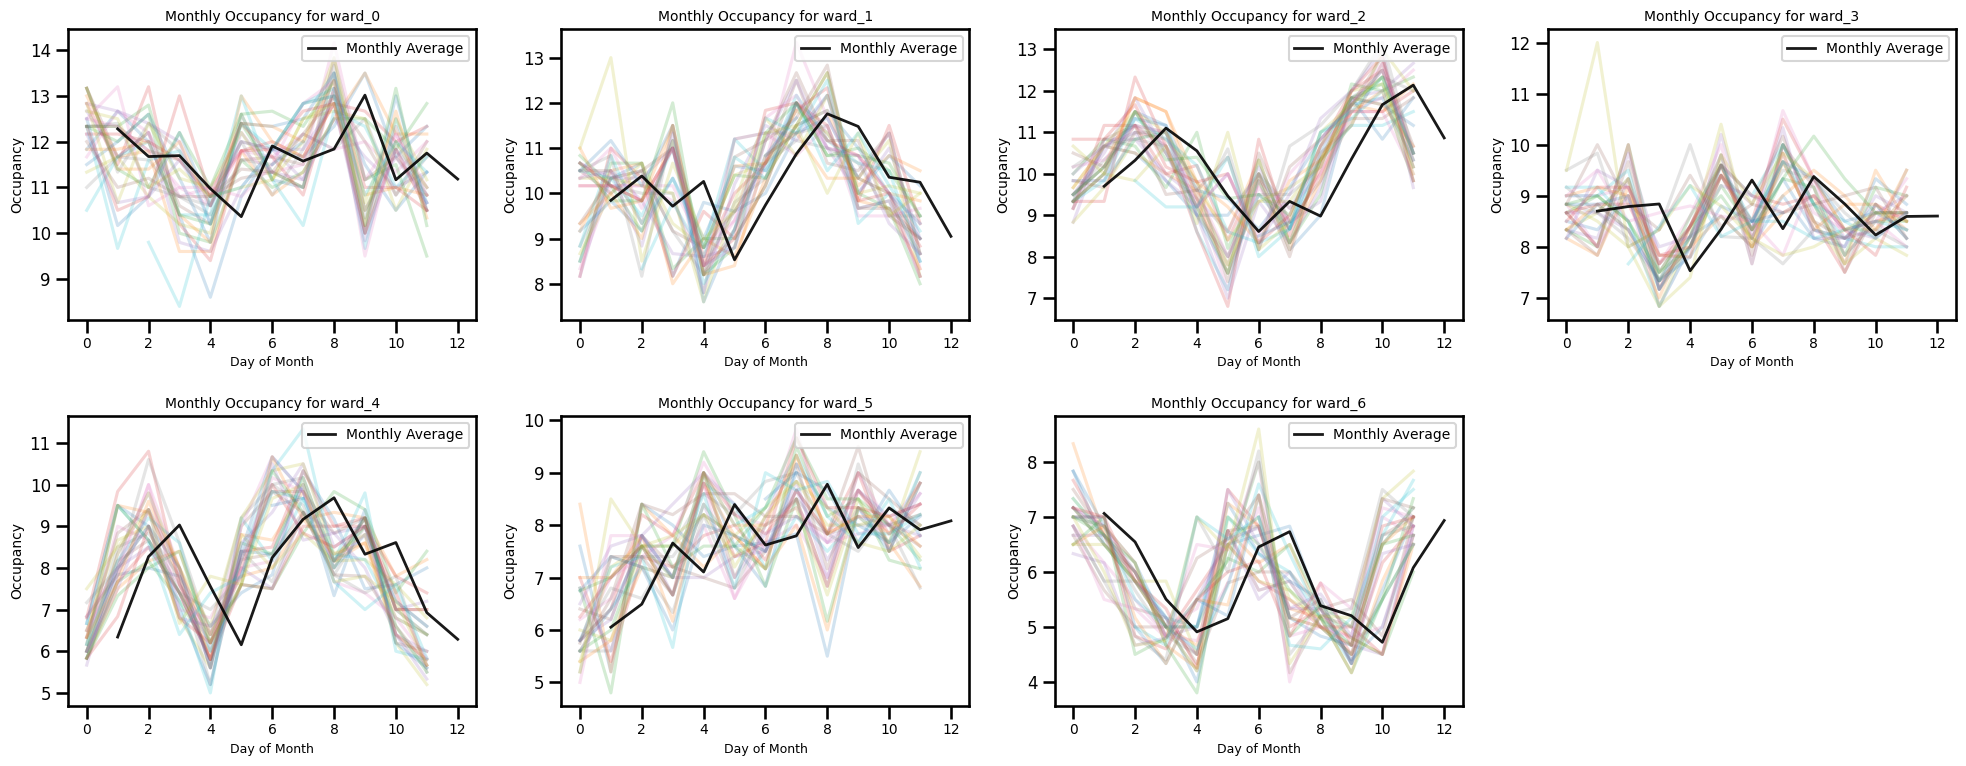

In [15]:
year_df = occup_train[occup_train["year"].isin([2019, 2020, 2021, 2022, 2023])]

# choose how many wards to plot
wards = [f"ward_{i}" for i in range(7)]  # e.g. 7 wards (0..6)
n_plots = len(wards)

# create a grid with enough slots (2 rows, 4 cols = 8 slots here)
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()  # flatten to index linearly

for ax, ward_col in zip(axes[:n_plots], wards):
        # Plot each week's data (less transparent)
        ward = occup_train.pivot_table(index="month", columns="day_of_month", values=ward_col, aggfunc='mean').reset_index()
        mean = occup_train.groupby('month')[ward_col].mean()
        for week in ward.columns[1:]:
            ax.plot(ward.index, ward[week], alpha=0.2)  # Less transparent

        # Plot average of all weeks (more transparent, thicker line)
        ax.plot(mean.index, mean, color='black', linewidth=2, alpha=0.9, label='Monthly Average')  # More transparent
        ax.set_xlabel("Day of Month", fontsize=9)
        ax.tick_params(axis='both', labelsize=9)  # <-- Correct way
        ax.tick_params(axis='x', labelsize=10)  # x-axis tick labels size
        ax.tick_params(axis='y', labelsize=12) # y-axis tick labels size
        ax.set_ylabel("Occupancy", fontsize=10)
        ax.set_title(f"Monthly Occupancy for {ward_col}", fontsize=10)
        ax.legend(loc='upper right', fontsize=10)

# remove any unused axes (if grid has more slots than n_plots)
for ax in axes[n_plots:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

## Occupancy by each month for eaxh year

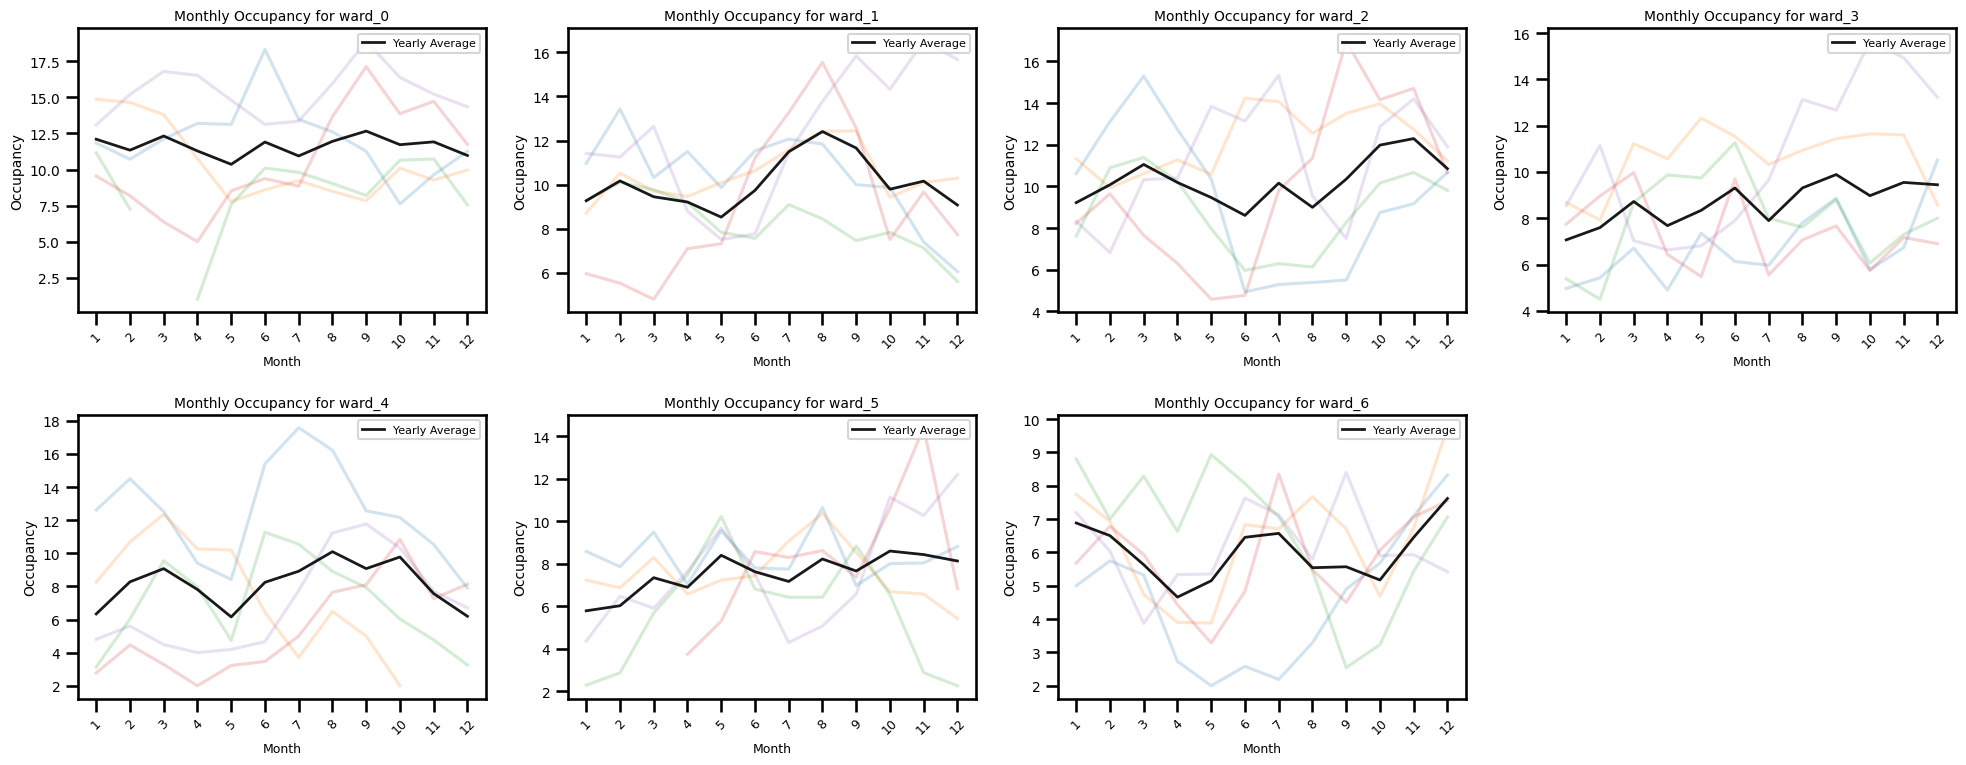

In [ ]:
year_df = occup_train[occup_train["year"].isin([2019, 2020, 2021, 2022, 2023])]

# choose how many wards to plot
wards = [f"ward_{i}" for i in range(7)]  # e.g. 7 wards (0..6)
n_plots = len(wards)

# create a grid with enough slots (2 rows, 4 cols = 8 slots here)
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()  # flatten to index linearly

for ax, ward_col in zip(axes[:n_plots], wards):
    ward = year_df.pivot_table(index="month", columns="year",
                               values=ward_col, aggfunc='mean').reset_index()
    mean = year_df.groupby('month')[ward_col].mean()

    # plot each year's monthly line (faint)
    for year in ward.columns[1:]:
        ax.plot(ward['month'], ward[year], alpha=0.2)

    # plot yearly average (bold)
    ax.plot(mean.index, mean, color='black', linewidth=2, alpha=0.9, label='Yearly Average')

    # ticks/labels
    ax.set_xlabel("Month", fontsize=9)
    ax.set_xticks(ward['month'])                         # positions = month labels
    ax.set_xticklabels(ward['month'], rotation=45, fontsize=9)  # show month names
    ax.tick_params(axis='y', labelsize=10)
    ax.set_ylabel("Occupancy", fontsize=10)
    ax.set_title(f"Monthly Occupancy for {ward_col}", fontsize=10)
    ax.legend(loc='upper right', fontsize=8, ncol=2)

# remove any unused axes (if grid has more slots than n_plots)
for ax in axes[n_plots:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

## Occupancy by weekends

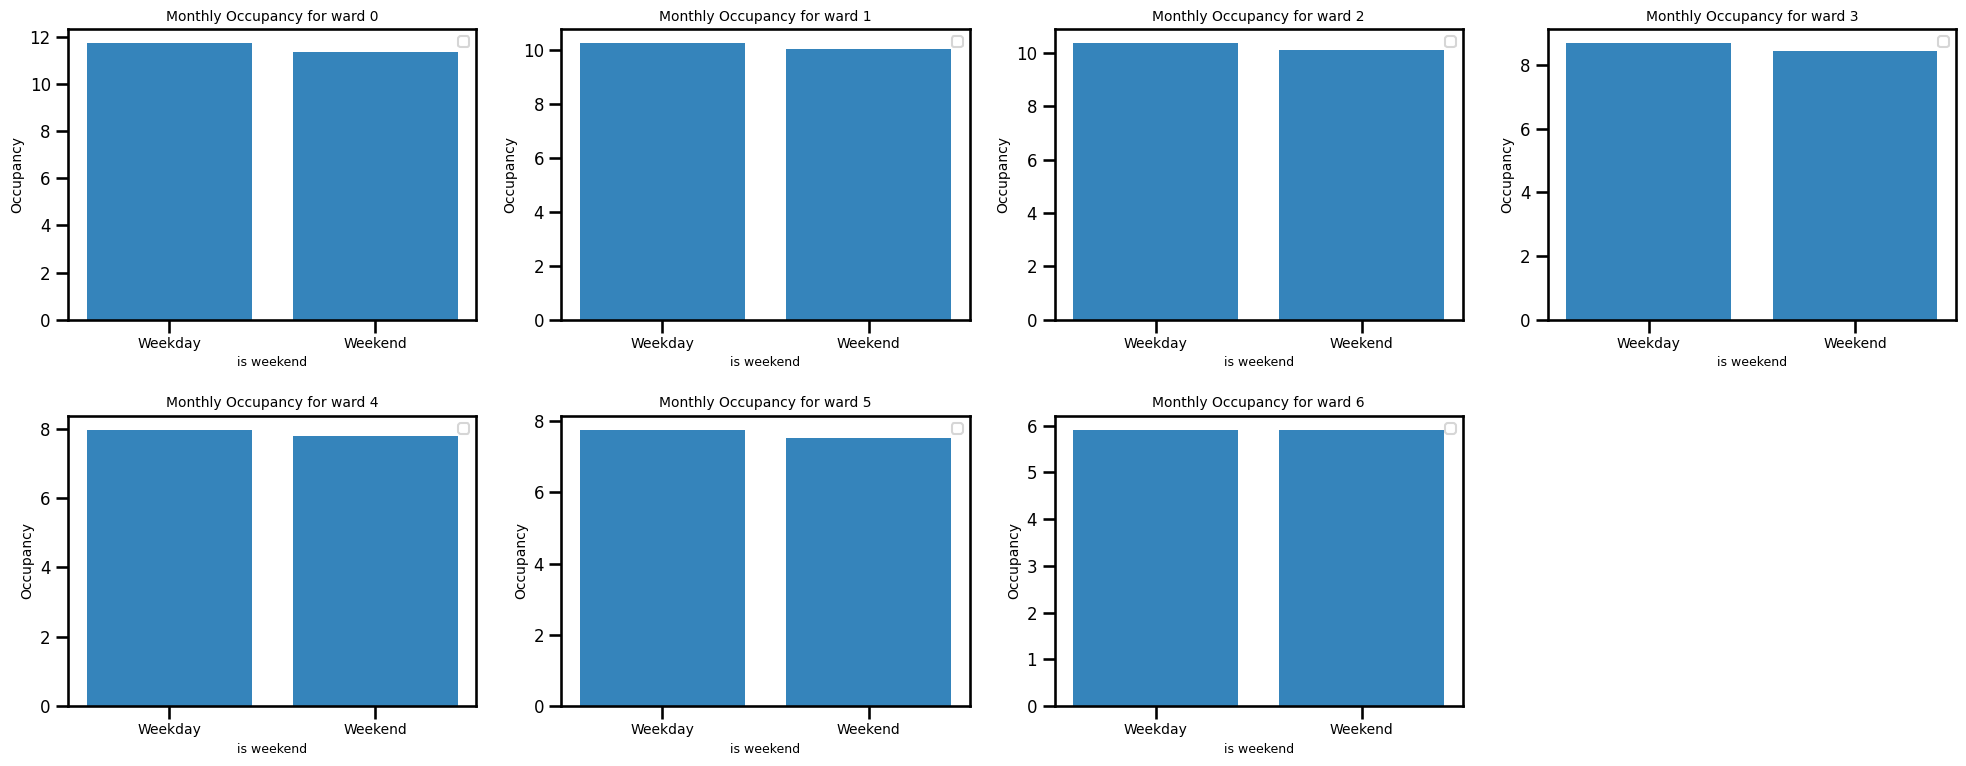

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()             # 8 axes, indexed 0..7

year_df = occup_train[occup_train["year"].isin([2019, 2020, 2021, 2022, 2023])]

for ward_num, ax in enumerate(axes[:7]):   # only use the first 7 axes
        mean = occup_train.groupby('is_weekend')[f"ward_{ward_num}"].mean()
        ax.bar(mean.index, mean, color='C0', alpha=0.9)
        # ax[i, j].bar(mean.index, mean, color='black', linewidth=2, alpha=0.9, label='Monthly Average')  # More transparent
        ax.set_xlabel("is weekend", fontsize=9)
        ax.set_xticks([0, 1], ["Weekday", "Weekend"], fontsize=12)  # <-- this changes tick labels
        ax.tick_params(axis='x', labelsize=10)  # x-axis tick labels size
        ax.tick_params(axis='y', labelsize=12) # y-axis tick labels size
        ax.set_ylabel("Occupancy", fontsize=10)
        ax.set_title(f"Monthly Occupancy for ward {ward_num}", fontsize=10)
        ax.legend(loc='upper right', fontsize=10)

# Optionally remove/hide any remaining axes (here there is one left)
for ax in axes[7:]:
    fig.delaxes(ax)            # removes the empty subplot from figure

plt.tight_layout()
plt.show()

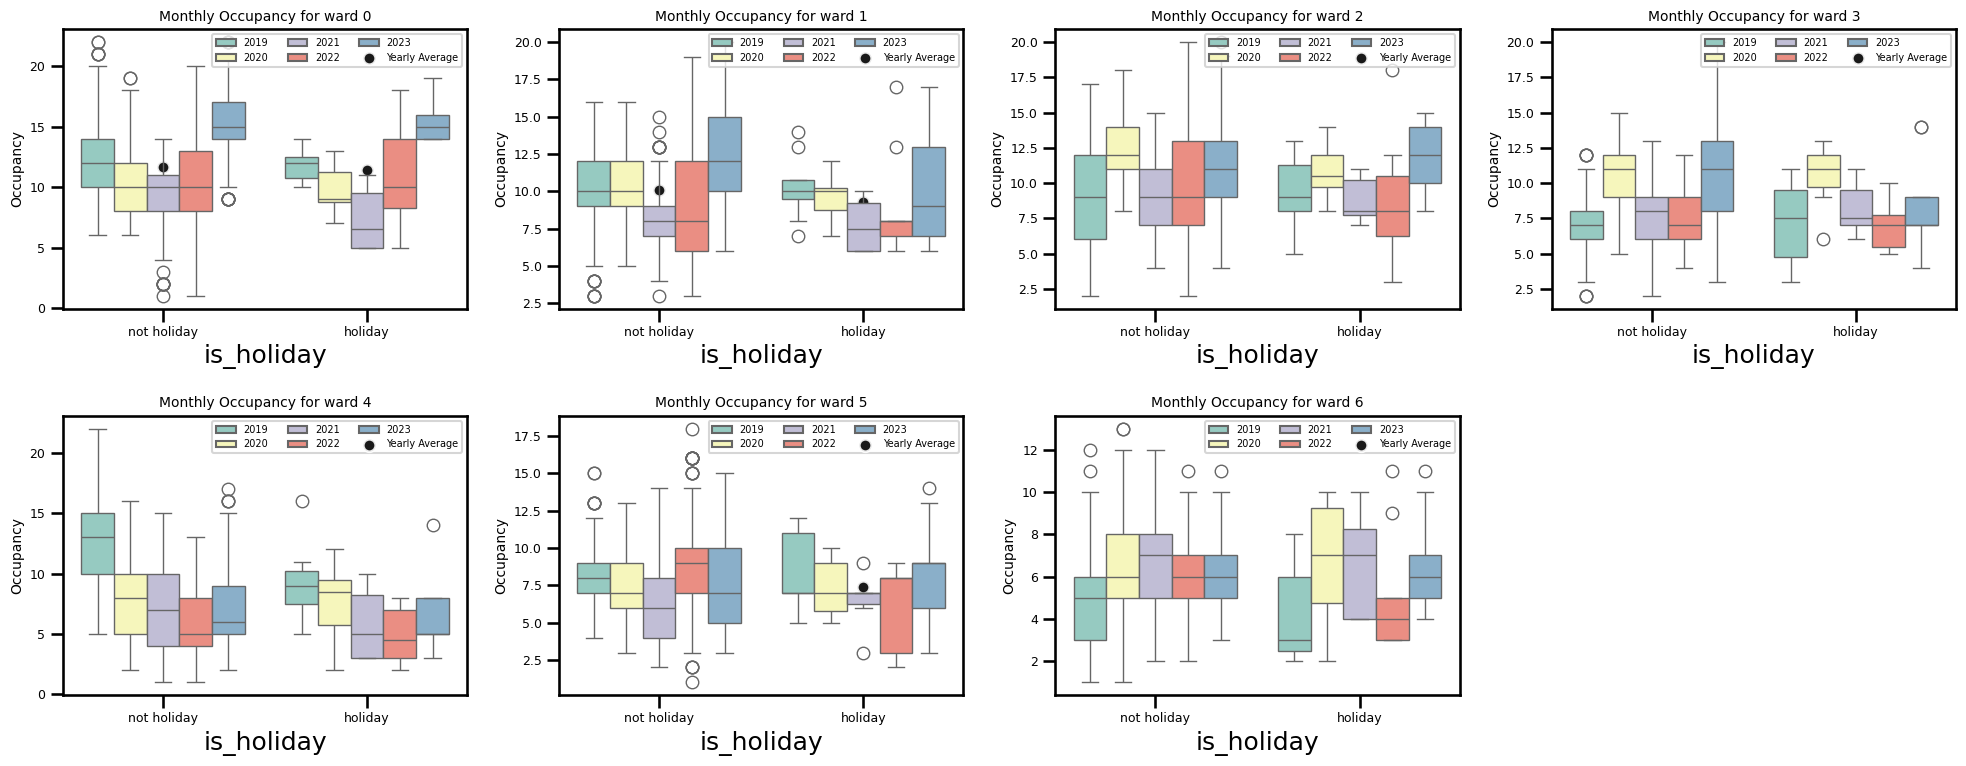

In [16]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()             # 8 axes, indexed 0..7

year_df = occup_train[occup_train["year"].isin([2019, 2020, 2021, 2022, 2023])]

for ward_num, ax in enumerate(axes[:7]):   # only use the first 7 axes
    sns.boxplot(x='is_holiday', y=f'ward_{ward_num}', data=year_df, hue='year',
                palette="Set3", ax=ax)
    mean = year_df.groupby('is_holiday')[f"ward_{ward_num}"].mean()
    sns.scatterplot(x=mean.index, y=mean, color='black', linewidth=2, alpha=0.9,
                    label='Yearly Average', ax=ax)

    ax.set_xticks([0, 1])
    ax.set_xticklabels(["not holiday", "holiday"], fontsize=12)
    ax.tick_params(axis='both', labelsize=9)
    ax.set_ylabel("Occupancy", fontsize=10)
    ax.set_title(f"Monthly Occupancy for ward {ward_num}", fontsize=10)
    ax.legend(loc='upper right', fontsize=7, ncol=3)

# Optionally remove/hide any remaining axes (here there is one left)
for ax in axes[7:]:
    fig.delaxes(ax)            # removes the empty subplot from figure

plt.tight_layout()
plt.show()

## Occupancy by the week of year

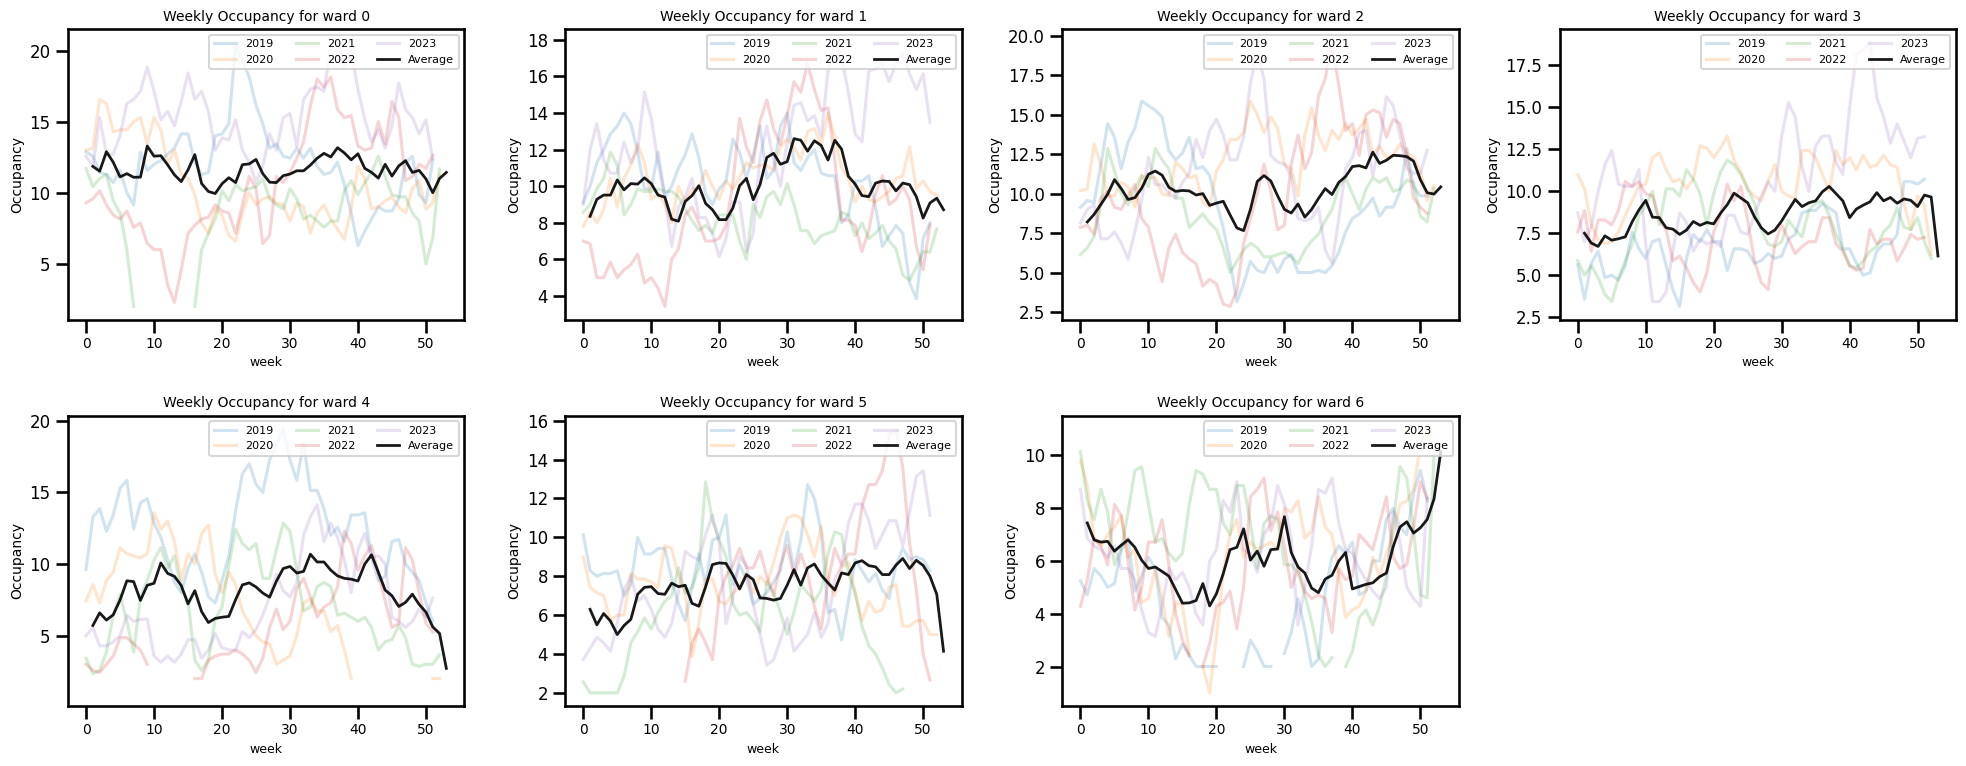

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()             # 8 axes, indexed 0..7

year_df = occup_train[occup_train["year"].isin([2019, 2020, 2021, 2022, 2023])]

for ward_num, ax in enumerate(axes[:7]):   # only use the first 7 axes
        # Plot each week's data (less transparent)
        ward = year_df.pivot_table(index="week_of_year", columns="year", values=f"ward_{ward_num}", aggfunc='mean').reset_index()
        mean = year_df.groupby('week_of_year')[f"ward_{ward_num}"].mean()
        for year in ward.columns[1:]:
            ax.plot(ward.index, ward[year], alpha=0.2, label=f"{year}")  # Less transparent

        # Plot average of all weeks (more transparent, thicker line)
        ax.plot(mean.index, mean, color='black', linewidth=2, alpha=0.9, label='Average')  # More transparent
        ax.set_xlabel("week", fontsize=9)
        ax.tick_params(axis='both', labelsize=9)  # <-- Correct way
        ax.tick_params(axis='x', labelsize=10)  # x-axis tick labels size
        ax.tick_params(axis='y', labelsize=12) # y-axis tick labels size
        ax.set_ylabel("Occupancy", fontsize=10)
        ax.set_title(f"Weekly Occupancy for ward {ward_num}", fontsize=10)
        ax.legend(loc='upper right', fontsize=8, ncol=3)

# Optionally remove/hide any remaining axes (here there is one left)
for ax in axes[7:]:
    fig.delaxes(ax)            # removes the empty subplot from figure

plt.tight_layout()
plt.show()

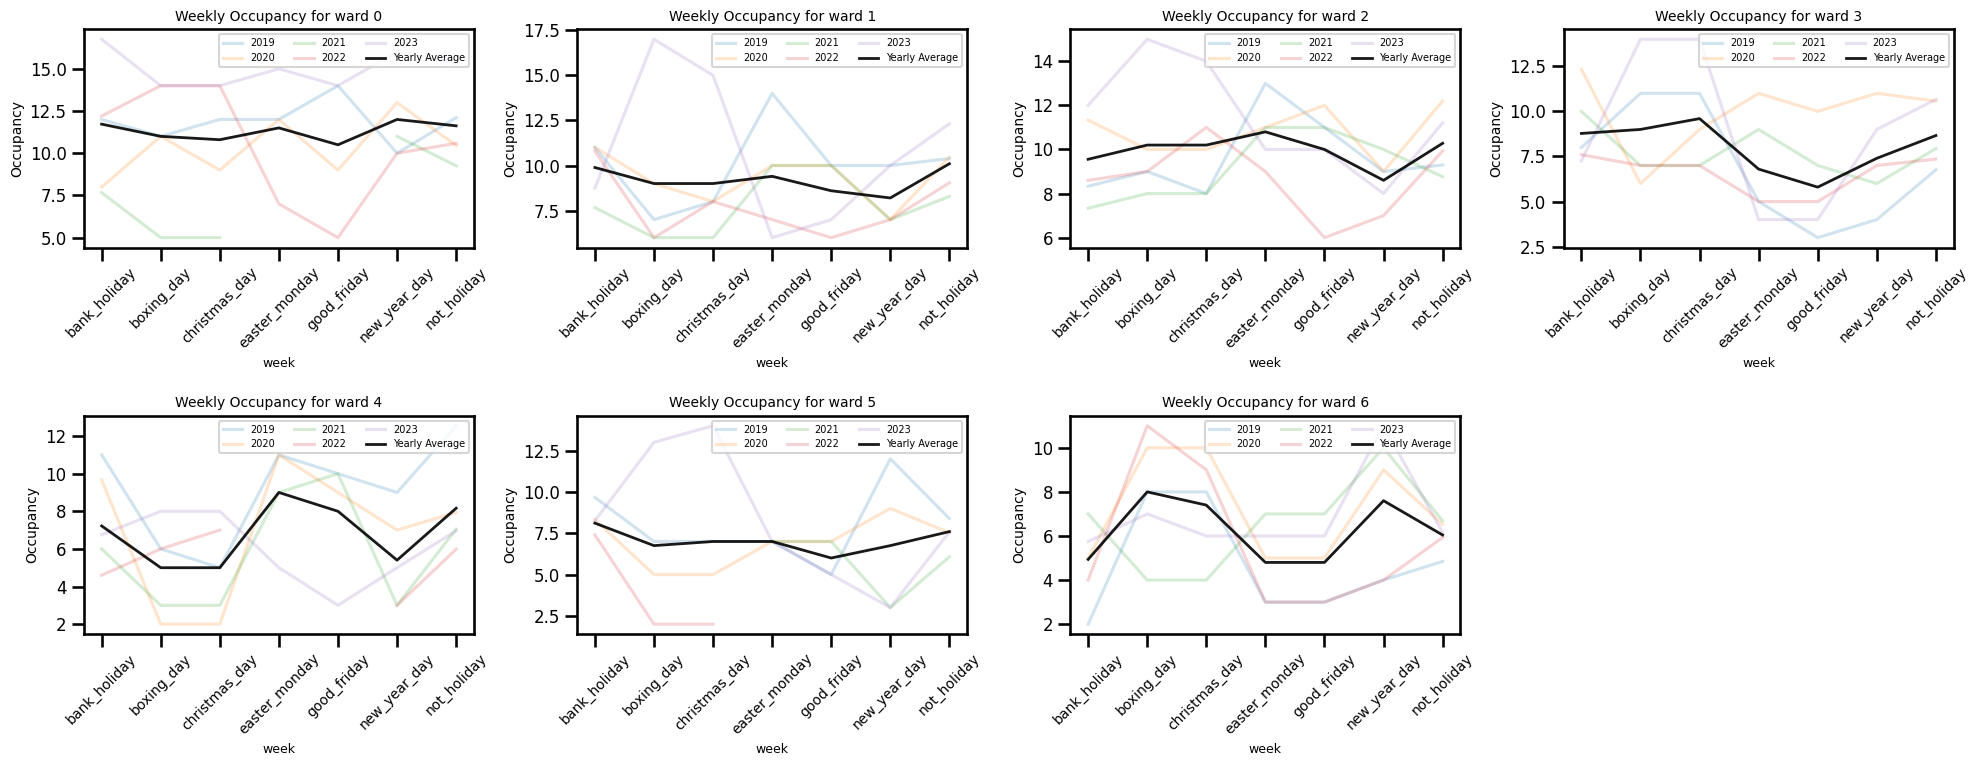

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
axes = axes.flatten()             # 8 axes, indexed 0..7

year_df = occup_train[occup_train["year"].isin([2019, 2020, 2021, 2022, 2023])]

for ward_num, ax in enumerate(axes[:7]):   # only use the first 7 axes
        # Plot each week's data (less transparent)
        ward = year_df.pivot_table(index="holiday", columns="year", values=f"ward_{ward_num}", aggfunc='mean').reset_index()
        mean = year_df.groupby('holiday')[f"ward_{ward_num}"].mean()
        for year in ward.columns[1:]:
            ax.plot(ward.index, ward[year], alpha=0.2, label=f"{year}")  # Less transparent

        # Plot average of all weeks (more transparent, thicker line)
        ax.plot(mean.index, mean, color='black', linewidth=2, alpha=0.9, label='Yearly Average')  # More transparent
        ax.set_xlabel("week", fontsize=9)
        ax.tick_params(axis='both', labelsize=9)  # <-- Correct way
        ax.tick_params(axis='x', labelsize=10, rotation=45)  # x-axis tick labels size
        ax.tick_params(axis='y', labelsize=12) # y-axis tick labels size
        ax.set_ylabel("Occupancy", fontsize=10)
        ax.set_title(f"Weekly Occupancy for ward {ward_num}", fontsize=10)
        ax.legend(loc='upper right', fontsize=7, ncol=3)

# Optionally remove/hide any remaining axes (here there is one left)
for ax in axes[7:]:
    fig.delaxes(ax)            # removes the empty subplot from figure

plt.tight_layout()
plt.show()

## Change point and outlier detection methods

In [7]:
import ruptures as rpt

In [8]:
def stl_data_input(series, period=7, seasonal=2999):
    # Apply STL decomposition
    res = STL(series.interpolate(method="linear").squeeze(), # Convert dataframe to a Series
                                                        # to avoid error in Statsmodels
            robust=True, period=period, seasonal=seasonal).fit()
    
    seasonal_component = res.seasonal
    # residual_component = res.resid
    # De-seasonlise original data
    df_deseasonalised = series - seasonal_component

    # # Perform linear interpolation on de-seasonalised data
    df_deseasonalised_imputed = df_deseasonalised.interpolate(method="linear")

    # # Randomly sample residuals (with replacement) and add back
    # sampled_residuals = np.random.choice(residual_component, size=len(residual_component), replace=True)
    # # Match DataFrame index
    # sampled_residuals = pd.Series(sampled_residuals, index=series.index)

    # # Add seasonal component back to get the final imputed time series
    df_imputed = df_deseasonalised_imputed + seasonal_component

    return df_imputed

## first input nan values using STL

In [9]:
for ward in ward_cols_:
    occup_train[ward] = stl_data_input(occup_train[ward], period=None, seasonal=2999)


## Ward 0 - Change point detection and imputation

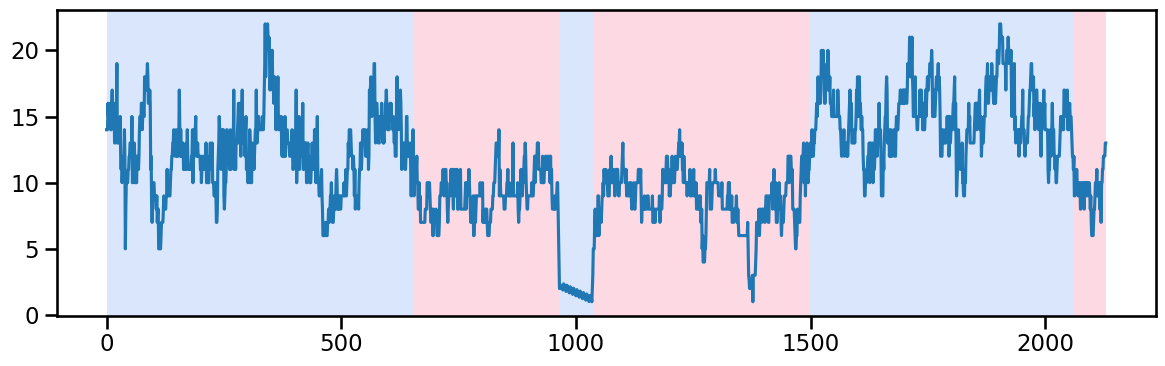

In [ ]:
y_00 = occup_train['ward_0'].values  # Example time series data
algo_rbf = rpt.Pelt(model="rbf").fit(y_00)
result_rbf_00 = algo_rbf.predict(pen=40)
rpt.display(y_00, result_rbf_00, figsize=(12, 4))
plt.show()

In [ ]:
result_rbf_00

[655, 965, 1040, 1500, 2060, 2130]

In [10]:
## replace the outlier values between 965 and 1040 by interpolation
occup_train_clean = occup_train.copy()
occup_train_nan = occup_train.copy()
occup_train_nan.iloc[965-1:1040+1, occup_train_nan.columns.get_loc('ward_0')] = np.nan
occup_train_clean['ward_0'] = stl_data_input(occup_train_nan['ward_0'], period=None, seasonal=2999)


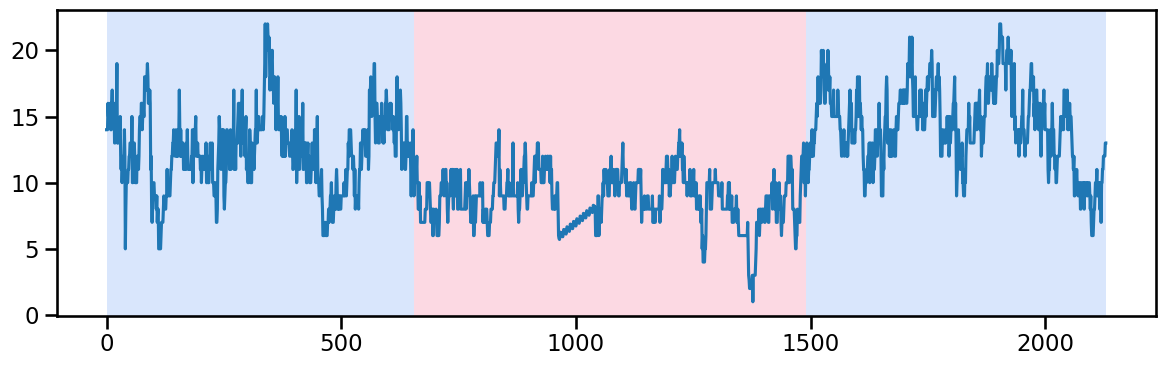

In [ ]:
y_01 = occup_train_clean["ward_0"].values  # Example time series data
algo_rbf = rpt.Pelt(model="rbf").fit(y_01)
result_rbf_01 = algo_rbf.predict(pen=50) ## best to try 1 and 3 piecewise (till 655, 655-1490 and 1490-...)
rpt.display(y_01, result_rbf_01, figsize=(12, 4))
plt.show()

In [ ]:
result_rbf_01
# change_points_ward_0 = [655, 1490], [1490] 

[655, 1490, 2130]

## Ward 1 - Change point detection and imputation

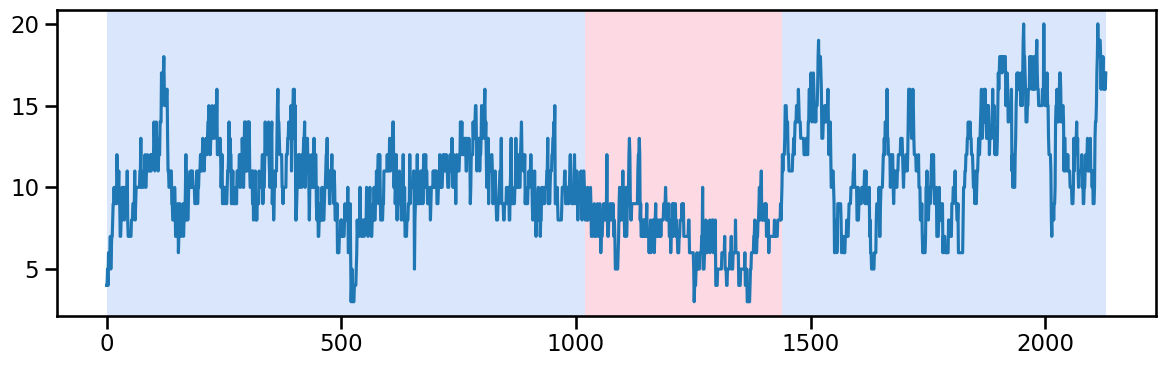

In [ ]:
y_10 = occup_train['ward_1'].values  # Example time series data
algo_rbf = rpt.Pelt(model="rbf").fit(y_10)
result_rbf_10 = algo_rbf.predict(pen=60) # best to try 1 and 2 with after 1440 break(till 1440, and 1440-...)
rpt.display(y_10, result_rbf_10, figsize=(12, 4))
plt.show()

In [ ]:
result_rbf_10

[1020, 1440, 2130]

In [ ]:
# change_points["ward_1"] = [1440], [1020, 1440]

## Ward 2 - Change point detection and imputation

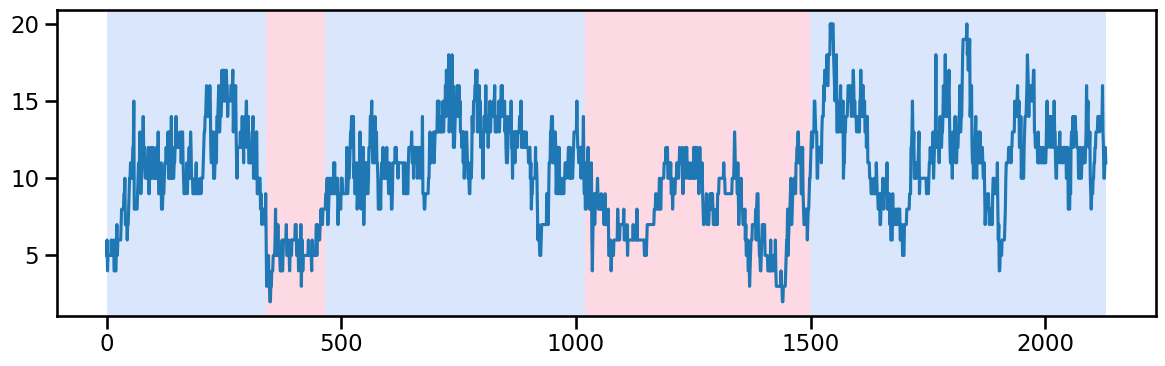

In [ ]:
y_20 = occup_train['ward_2'].values  # Example time series data
algo_rbf = rpt.Pelt(model="rbf").fit(y_20)
result_rbf_20 = algo_rbf.predict(pen=50) # best to try 1 and 2 with after 1500 break(till 1500, and 1500-...)
rpt.display(y_20, result_rbf_20, figsize=(12, 4))
plt.show()

In [ ]:
result_rbf_20

[340, 465, 1020, 1500, 2130]

## Ward 3 - Change point detection and imputation

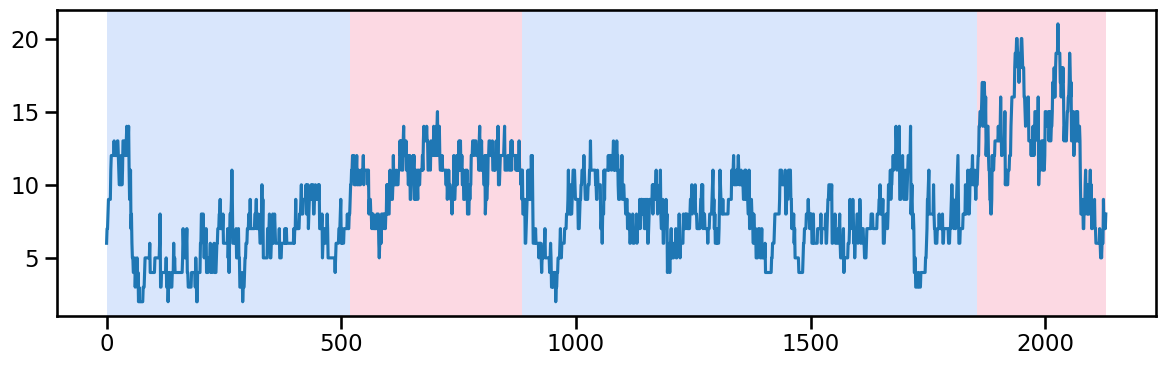

In [ ]:
y_30 = occup_train['ward_3'].values  # Example time series data
algo_rbf = rpt.Pelt(model="rbf").fit(y_30)
result_rbf_30 = algo_rbf.predict(pen=50) # best to try just 1 because the changes are subtle and the last change has less data points
rpt.display(y_30, result_rbf_30, figsize=(12, 4))
plt.show()

In [ ]:
result_rbf_30

[520, 885, 1855, 2130]

## Ward 4 - Change point detection and imputation

In [ ]:
y_40 = occup_train['ward_4'].values  # Example time series data
algo_rbf = rpt.Pelt(model="rbf").fit(y_40)
result_rbf_40 = algo_rbf.predict(pen=35)
rpt.display(y_40, result_rbf_40, figsize=(12, 4))
plt.show()

KeyboardInterrupt: 

In [ ]:
result_rbf_40

[175, 705, 815, 945, 1215, 1475, 1630, 1830, 2130]

In [12]:
## replace the outlier values between 815 and 945 by interpolation where they were also NaN values before interpolation 
# occup_train_nan = occup_train.copy()
occup_train_nan.iloc[815-1:945+1, occup_train_nan.columns.get_loc('ward_4')] = np.nan
occup_train_clean['ward_4'] = stl_data_input(occup_train_nan['ward_4'], period=None, seasonal=2999)

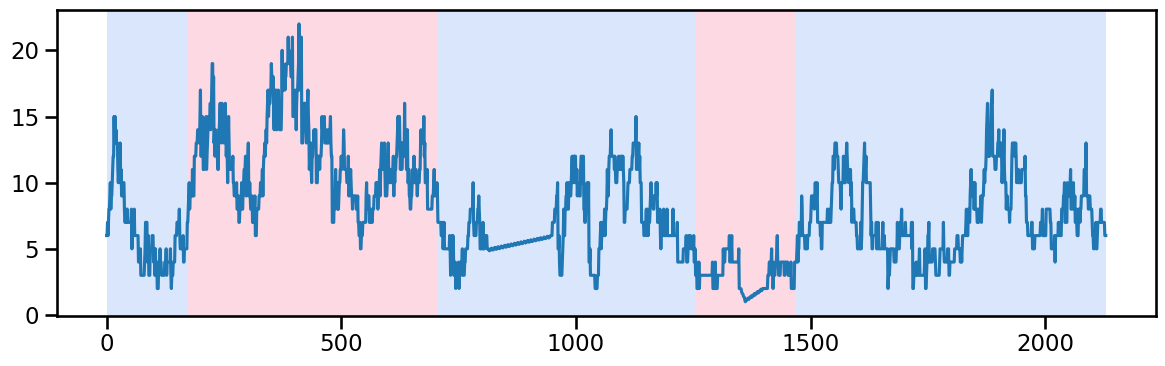

In [ ]:
y_41 = occup_train_clean['ward_4'].values  # Example time series data
algo_rbf = rpt.Pelt(model="rbf").fit(y_41)
result_rbf_41 = algo_rbf.predict(pen=50) ## try linear trend and 2 piecewise trend for ward_4 (after 705)
rpt.display(y_41, result_rbf_41, figsize=(12, 4))
plt.show()

In [ ]:
result_rbf_41

[175, 705, 1255, 1470, 2130]

In [ ]:
change_points_ward_4 = [705], [1255]

## Ward 5 - Change point detection and imputation

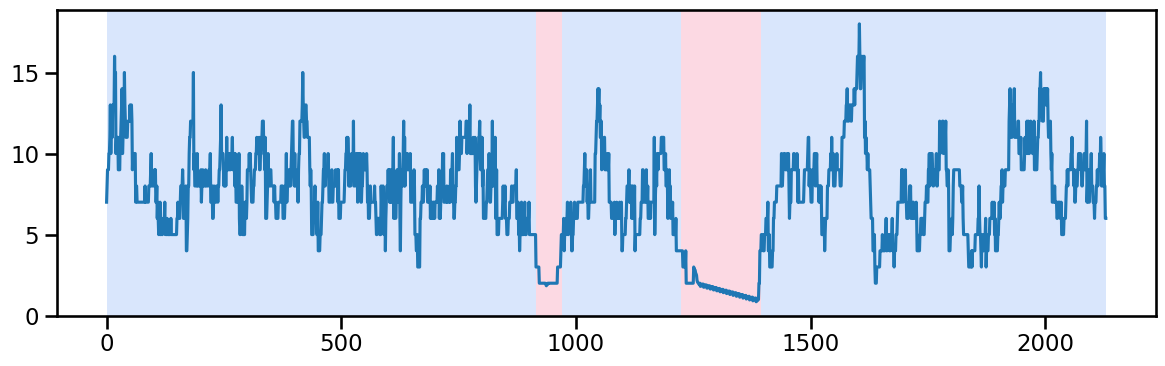

In [ ]:
y_50 = occup_train['ward_5'].values  # Example time series data
algo_rbf = rpt.Pelt(model="rbf").fit(y_50)
result_rbf_50 = algo_rbf.predict(pen=35)
rpt.display(y_50, result_rbf_50, figsize=(12, 4))
plt.show()

In [ ]:
result_rbf_50

[915, 970, 1225, 1395, 2130]

In [15]:
## replace the outlier values between 1215 and 1395 by interpolation
occup_train_nan.iloc[915-1:970+1, occup_train_nan.columns.get_loc('ward_5')] = np.nan
occup_train_nan.iloc[1215-1:1395+1, occup_train_nan.columns.get_loc('ward_5')] = np.nan
occup_train_clean['ward_5'] = stl_data_input(occup_train_nan['ward_5'], period=None, seasonal=2999)

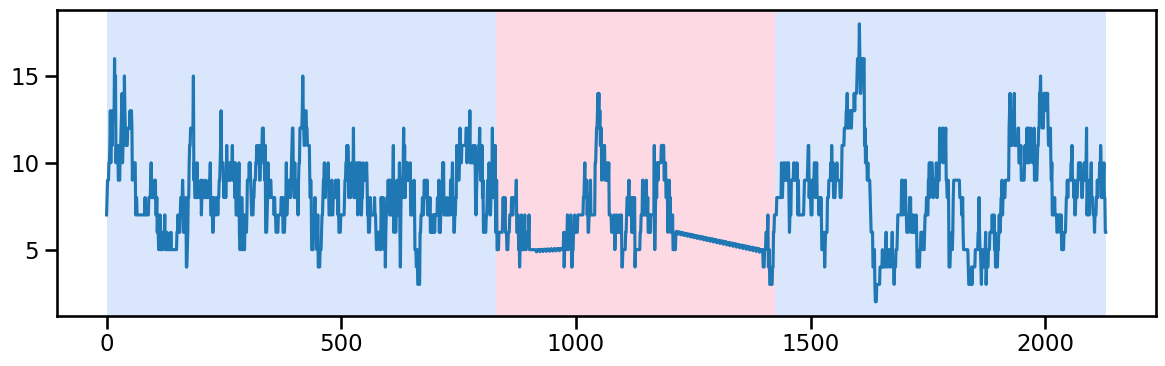

In [16]:
y_51 = occup_train_clean['ward_5'].values  # Example time series data
algo_rbf = rpt.Pelt(model="rbf").fit(y_51)
result_rbf_51 = algo_rbf.predict(pen=50) ## try linear trend and 3 piecewise trend for ward_5 (830, 830-1425, and 1425+)
rpt.display(y_51, result_rbf_51, figsize=(12, 4))
plt.show()

In [ ]:
result_rbf_51

[830, 1425, 2130]

In [ ]:
change_points_ward_5 = [830, 1425]

## Ward 6 - Change point detection and imputation

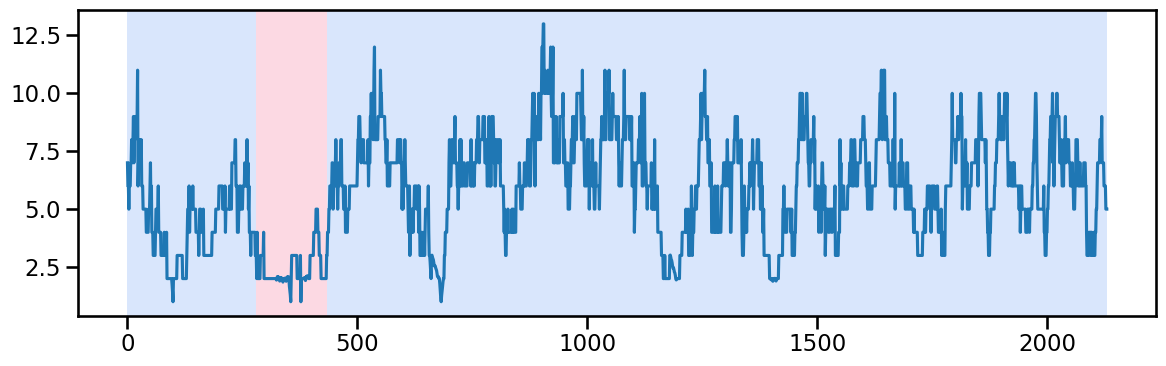

In [ ]:
y_60 = occup_train['ward_6'].values  # Example time series data
algo_rbf = rpt.Pelt(model="rbf").fit(y_60)
result_rbf_60 = algo_rbf.predict(pen=40) # better to just try 1 because the only change is in the begining which might reflect the nature of data
rpt.display(y_60, result_rbf_60, figsize=(12, 4))
plt.show()

In [13]:
# change_points = {"ward_0": change_points_ward_0, "ward_1": change_points_ward_1, "ward_2": change_points_ward_2,
#                  "ward_4": change_points_ward_4, "ward_5": change_points_ward_5}

In [16]:
# # Save to file
# with open('model_params/change_points.pkl', 'wb') as f:
#     pickle.dump(change_points, f)

# Load from file
with open('model_params/change_points.pkl', 'rb') as f:
    change_points = pickle.load(f)

## guerrero transformation

In [17]:

# from sktime.transformations.series.boxcox import BoxCoxTransformer
# guerrero_lambdas = {}
# for w in ward_cols_:
#     # Make transformer and perform Box-Cox transform
#     transformer = BoxCoxTransformer(
#         method="guerrero",
#         sp=7 # sp should be set to the seasonal period
#     )  

#     transformer.fit_transform(occup_train_clean[w])
#     guerrero_lambdas[w] = transformer.lambda_

# # Save to file
# with open('model_params/guerrero_lambdas.pkl', 'wb') as f:
#     pickle.dump(guerrero_lambdas, f)

# Load from file
with open('model_params/guerrero_lambdas.pkl', 'rb') as f:
    guerrero_lambdas = pickle.load(f)

In [ ]:
fitted_trend0, model_tr0 = lr_trend_model(occup_train_clean["ward_0"], breakpoints=[655], type='piecewise')
fitted_trend_lr0, model_lr0 = lr_trend_model(occup_train_clean["ward_0"])

forecast360_w0 = forecast_trend(model=model_tr0, H=360, start=len(occup_train_clean["ward_0"]), breakpoints=[655])
forecast360_lr0 = forecast_trend(model=model_lr0, H=360, start=len(occup_train_clean["ward_0"]))

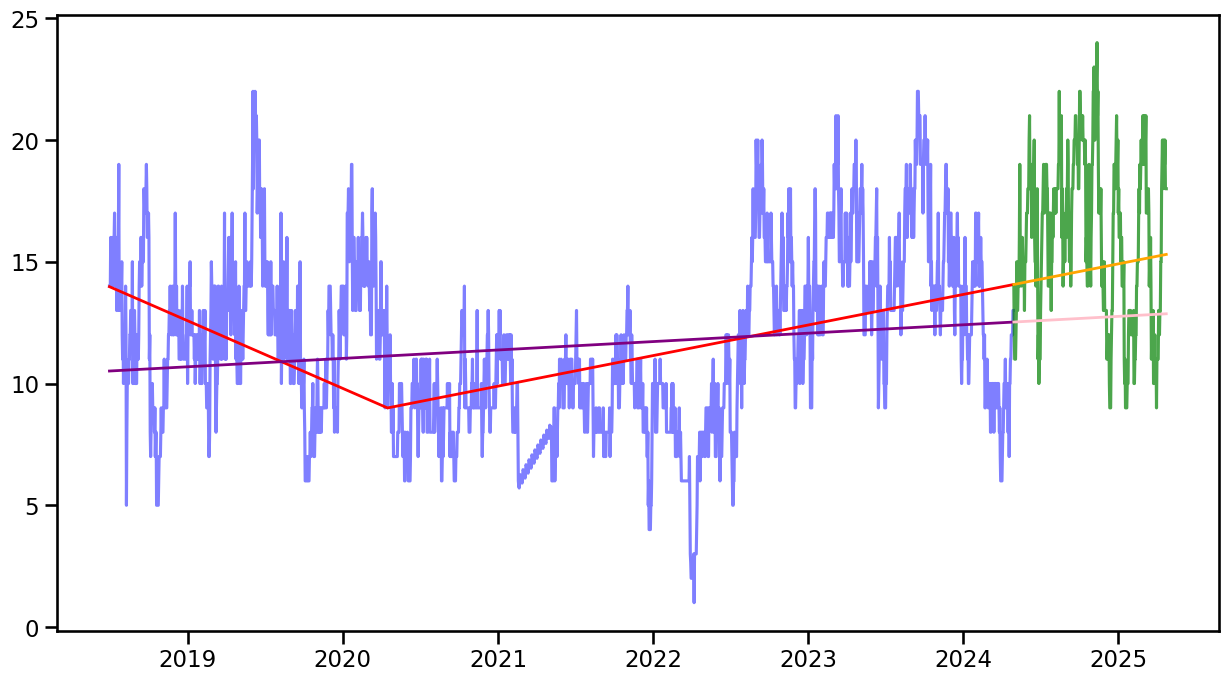

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(occup_train_clean.index, (occup_train_clean["ward_0"]), label="Original Data", color='blue', alpha=0.5)
ax.plot(occup_train_clean.index, fitted_trend0, label="Fitted Trend", color='red', linewidth=2)
ax.plot(occup_train_clean.index, fitted_trend_lr0, label="Fitted Trend", color='purple', linewidth=2)
ax.plot(occup_test.index, occup_test["ward_0"], label="Detrended Data", color='green', alpha=0.7)
ax.plot(occup_test.index, forecast360_w0, label="Forecasted Trend", color='orange', linewidth=2)
ax.plot(occup_test.index, forecast360_lr0, label="Forecasted Trend", color='pink', linewidth=2)

In [ ]:
# RMSE(occup_test["ward_2"], forecast360_w2), RMSE(occup_test["ward_2"], forecast360_lr2)

(np.float64(3.8212542303129404), np.float64(5.129657020736392))

In [ ]:
def cross_validate_trend(series, cv_split, test_size, metrics, type = "linear", break_points = None, step_size=None):
    """
    Run cross-validation using time series splits.

    Args:
        model (class): Machine learning model class (e.g., CatBoostRegressor, LGBMRegressor).
        df (pd.DataFrame): Input data.
        cv_split (int): Number of splits in TimeSeriesSplit.
        test_size (int): Size of test window.
        metrics (list): List of metric functions.
    
    Returns:
        pd.DataFrame: Performance metrics for CV.
    """
    tscv = ParametricTimeSeriesSplit(n_splits=cv_split, test_size=test_size, step_size=step_size)
    metrics_dict = {m.__name__: [] for m in metrics}
    for train_index, test_index in tscv.split(series):
        train, test = series[train_index], series[test_index]
        fitted_trend, model_ = lr_trend_model(train, breakpoints=break_points, type= type)
        forecast = forecast_trend(model=model_, H=test_size, start=len(train), breakpoints=break_points)
        # Evaluate each metric
        for m in metrics:
            if m.__name__ in ["MASE", "SMAE", "SRMSE", "RMSSE"]:
                eval_val = m(np.array(test), forecast, train)
            else:
                eval_val = m(np.array(test), forecast)
            metrics_dict[m.__name__].append(eval_val)
    overall_performance = [[m.__name__, np.mean(metrics_dict[m.__name__])] for m in metrics]
    return pd.DataFrame(overall_performance).rename(columns={0: "eval_metric", 1: "score"})

In [ ]:
cross_validate_trend(series=occup_train_clean["ward_0"], cv_split=10, test_size=30, step_size=1, metrics=[SRMSE, MAE, RMSE, MASE], type='piecewise', break_points=[655])

eval_metric     score
0       SRMSE  0.498297
1         MAE  5.501857
2        RMSE  5.757344
3        MASE  6.703189

In [ ]:
cross_validate_trend(series=occup_train_clean["ward_0"], cv_split=10, test_size=30, step_size=1, metrics=[SRMSE, MAE, RMSE, MASE], type='linear', break_points=None)

eval_metric     score
0       SRMSE  0.360618
1         MAE  3.803619
2        RMSE  4.166597
3        MASE  4.634138

In [ ]:
# score_list = []
# for b in range(500, 1900):
#     cv = cross_validate_trend(series=occup_train_clean["ward_0"], cv_split=30, test_size=30, step_size=1, metrics=[MAE, RMSE, MASE], type='piecewise', break_points=[b])
#     score = [b]+cv["score"].tolist()
#     score_list.append(score)

#### Cross-validation results for trend forecasting

-  For Ward 0, use normal linear regression, perform better than piecewise linear regression.
-  For Ward 1, use piecewise linear regression, perform better than normal linear regression.
-  For Ward 2, use piecewise linear regression, perform better than normal linear regression.
- For Ward 3, use normal linear regression, perform better than piecewise linear regression.
-  For Ward 4, use piecewise linear regression, perform better than normal linear regression. just 1255
-  For Ward 5, use piecewise linear regression, perform better than normal linear regression.



In [18]:
# trend_lr_models = pd.DataFrame([["ward_0", "linear regression", np.nan],
#  ["ward_1", "piecewise regression", 1440],
#  ["ward_2", "piecewise regression", 1500],
#  ["ward_3", "linear regression", np.nan],
#  ["ward_4", "piecewise regression", 1255],
#  ["ward_5", "piecewise regression", [830, 1425]],
#  ["ward_6", "linear regression", np.nan]]).rename(columns={0: "ward", 1: "model", 2: "breakpoint"})

# # Save to file
# with open('model_params/trend_lr_models.pkl', 'wb') as f:
#     pickle.dump(trend_lr_models, f)

# Load from file
with open('model_params/trend_lr_models.pkl', 'rb') as f:
    trend_lr_models = pickle.load(f)

In [ ]:
# var_rmse = []
# for i in range(3, 3000, 2):
#     res = STL(occup_train_clean["ward_0"], period=7, seasonal=i).fit()
#     var_rmse.append([i, np.var(res.resid), np.sqrt((res.resid**2).mean())])
# df_result = pd.DataFrame(var_rmse, columns=["seasonal", "var", "rmse"])
# df_result.sort_values(by="rmse")

In [ ]:

# for w in ward_cols_:
#     strength = seasonality_strength(occup_train_clean[w], period=7, seasonal=3)
#     print(f"seasonality_strength for {w}: {strength}")
# for w in ward_cols_:
#     strength = trend_strength(occup_train_clean[w], period=7, seasonal=3)
#     print(f"trend_strength for {w}: {strength}")

## ACF test and PACF test

In [ ]:
# Stationary check for each ward using ADF test and KPSS
for ward in ward_cols_:
    print(f"Unit root test for {ward}:")
    unit_root_test(occup_train_clean[ward], n_lag=26, method="ADF")
    unit_root_test(occup_train_clean[ward], n_lag=20, method="KPSS")

Unit root test for ward_0:
ADF p-value: 0.000796 and data is stationary at 5% significance level
KPSS p-value: 0.010000 and data is non-stationary at 5% significance level
Unit root test for ward_1:
ADF p-value: 0.006183 and data is stationary at 5% significance level
KPSS p-value: 0.010000 and data is non-stationary at 5% significance level
Unit root test for ward_2:
ADF p-value: 0.000232 and data is stationary at 5% significance level
KPSS p-value: 0.047429 and data is non-stationary at 5% significance level
Unit root test for ward_3:
ADF p-value: 0.000318 and data is stationary at 5% significance level
KPSS p-value: 0.010000 and data is non-stationary at 5% significance level
Unit root test for ward_4:
ADF p-value: 0.000184 and data is stationary at 5% significance level
KPSS p-value: 0.010000 and data is non-stationary at 5% significance level
Unit root test for ward_5:
ADF p-value: 0.000000 and data is stationary at 5% significance level
KPSS p-value: 0.100000 and data is stationa

In [ ]:
# from statsmodels.tsa.stattools import adfuller
# def adf_lag(y):
#     # Run ADF test with automatic lag selection using AIC and BIC
#     adf_aic = adfuller(y, autolag="AIC")
#     adf_bic = adfuller(y, autolag="BIC")

#     auto_results = pd.DataFrame({
#         "Criterion": ["AIC", "BIC"],
#         "ADF Statistic": [adf_aic[0], adf_bic[0]],
#         "p-value": [adf_aic[1], adf_bic[1]],
#         "Used Lags": [adf_aic[2], adf_bic[2]]
#     })
#     return auto_results


In [19]:
occup_train_guerrero = occup_train_clean.copy()

for w in ward_cols_:
    # Apply the Box-Cox transformation using the saved lambda
    occup_train_guerrero[w] = box_cox_transform(occup_train_clean[w],
                                                box_cox_lmda=guerrero_lambdas[w])[0]

In [ ]:
# Stationary check for each ward using ADF test and KPSS
for ward in ward_cols_:
    print(f"Unit root test for {ward}:")
    unit_root_test(occup_train_guerrero[ward], n_lag=10, method="ADF")
    unit_root_test(occup_train_guerrero[ward], n_lag=10, method="KPSS")

Unit root test for ward_0:
ADF p-value: 0.000027 and data is stationary at 5% significance level
KPSS p-value: 0.010000 and data is non-stationary at 5% significance level
Unit root test for ward_1:
ADF p-value: 0.000006 and data is stationary at 5% significance level
KPSS p-value: 0.010000 and data is non-stationary at 5% significance level
Unit root test for ward_2:
ADF p-value: 0.000010 and data is stationary at 5% significance level
KPSS p-value: 0.010000 and data is non-stationary at 5% significance level
Unit root test for ward_3:
ADF p-value: 0.000178 and data is stationary at 5% significance level
KPSS p-value: 0.010000 and data is non-stationary at 5% significance level
Unit root test for ward_4:
ADF p-value: 0.000270 and data is stationary at 5% significance level
KPSS p-value: 0.010000 and data is non-stationary at 5% significance level
Unit root test for ward_5:
ADF p-value: 0.000000 and data is stationary at 5% significance level
KPSS p-value: 0.020208 and data is non-stat

In [ ]:
# occup_train_fe = occup_train_clean.copy()

# ## Since whole wards are non-stationary, first we detrended using differencing and also difference between original series-linear trends to try both
# for ward, model in zip(ward_cols_, trend_lr_models["model"]):
#     occup_train_fe[f"{ward}_diff"] = occup_train_fe[ward].diff()
#     occup_train_fe[f"{ward}_gr_diff"] = occup_train_guerrero[ward].diff()
#     br = list(trend_lr_models.loc[trend_lr_models["ward"]==ward, "breakpoint"])
#     if ward == "ward_5":
#         br = br[0]
#     # print(f"breakpoints for {ward}: {br}")
#     if model == "linear regression":
#         occup_train_fe[f"{ward}_lr_diff"] = occup_train_fe[ward] - lr_trend_model(occup_train_fe[ward])[0]
#         occup_train_fe[f"{ward}_gr_lr_diff"] = occup_train_guerrero[ward] - lr_trend_model(occup_train_guerrero[ward])[0]
#     else:
#         occup_train_fe[f"{ward}_lr_diff"] = occup_train_fe[ward] - lr_trend_model(occup_train_fe[ward], breakpoints=br,  type="piecewise")[0]
#         occup_train_fe[f"{ward}_gr_lr_diff"] = occup_train_guerrero[ward] - lr_trend_model(occup_train_guerrero[ward], breakpoints=br, type="piecewise")[0]

# ## Then since referrals from CMHTs and follow-ups to CMHTs are intermitted, we create rolling window features to see if there might be significant patterns
# windows= [14, 21, 28, 30, 35, 42, 60, 90]
# for window in windows:
#     # occup_train_fe[f"cmh_refer_w{window}_sum"] = occup_train_fe["cmht_refer"].rolling(window=window).sum()
#     occup_train_fe[f"cmh_refer_w{window}_mean"] = occup_train_fe["cmht_refer"].rolling(window=window).mean()
#     occup_train_fe[f"cmh_refer_w{window}_std"] = occup_train_fe["cmht_refer"].rolling(window=window).std()
#     # occup_train_fe[f"cmh_refer_w{window}_mean_diff"] = occup_train_fe[f"cmh_refer_w{window}_mean"].diff(1)
#     # occup_train_fe[f"cmh_refer_w{window}_std_diff"] = occup_train_fe[f"cmh_refer_w{window}_std"].diff(1)
# # occup_train_fe[f"cmh_refer_expand_mean30"] = occup_train_fe["cmht_refer"].shift(30).expanding().mean()
# # occup_train_fe[f"cmh_refer_expand_std30"] = occup_train_fe["cmht_refer"].shift(30).expanding().std()

# for window in windows:
#     # occup_train_fe[f"cmh_follow_w{window}_sum"] = occup_train_fe["cmht_followup"].rolling(window=window).sum()
#     occup_train_fe[f"cmh_follow_w{window}_mean"] = occup_train_fe["cmht_followup"].rolling(window=window).mean()
#     occup_train_fe[f"cmh_follow_w{window}_std"] = occup_train_fe["cmht_followup"].rolling(window=window).std()
#     # occup_train_fe[f"cmh_follow_w{window}_mean_diff"] = occup_train_fe[f"cmh_follow_w{window}_mean"].diff(1)
#     # occup_train_fe[f"cmh_follow_w{window}_std_diff"] = occup_train_fe[f"cmh_follow_w{window}_std"].diff(1)

# # occup_train_fe[f"cmh_follow_expand_mean30"] = occup_train_fe["cmht_followup"].shift(30).expanding().mean()
# # occup_train_fe[f"cmh_follow_expand_std30"] = occup_train_fe["cmht_followup"].shift(30).expanding().std()

# occup_train_fe.dropna(inplace=True)
# occup_train_fe = occup_train_fe.drop(columns=["year", "holiday"])


# ## Feature Engineering for Wards
# fe_wards = occup_train_fe.filter(regex=r'ward_.*_.*gr_', axis=1)
# # fe_w1 = occup_train_fe.filter(like="ward_1", axis=1)
# # fe_w2 = occup_train_fe.filter(like="ward_2", axis=1)
# # fe_w3 = occup_train_fe.filter(like="ward_3", axis=1)
# # fe_w4 = occup_train_fe.filter(like="ward_4", axis=1)
# # fe_w5 = occup_train_fe.filter(like="ward_5", axis=1)
# # fe_w6 = occup_train_fe.filter(like="ward_6", axis=1)
# fe_refer = occup_train_fe.filter(like="cmh_refer_", axis=1)
# fe_follow = occup_train_fe.filter(like="cmh_follow_", axis=1)
# # fe_refer = fe_refer.drop(fe_refer.filter(like="_sum").columns, axis=1)

In [ ]:
# ccf_strength(fe_wards["ward_1_gr_lr_diff"], fe_refer["cmh_refer_w60_mean"],
#              adjusted=True, n_lags=90)[["lags", "ccf_value"]].reset_index(drop=True)

In [17]:
param_space_s = {"trend": hp.choice("trend", [None, "add", "mul"]),
         "seasonal": hp.choice("seasonal", [None, "add", "mul"]),
                 "seasonal_periods":7,
        "damped_trend": hp.choice("damped_trend", [True, False]),
    'smoothing_level': hp.uniform('smoothing_level', 0, 0.99),
    'smoothing_trend': hp.uniform('smoothing_trend', 0, 0.99),
    'smoothing_seasonal': hp.uniform('smoothing_seasonal', 0, 0.99),
    'damping_trend': hp.uniform('damping_trend', 0, 0.99)
}

param_space_t = {"trend": hp.choice("trend", [None, "add", "mul"]),
        "damped_trend": hp.choice("damped_trend", [True, False]),
    'smoothing_level': hp.uniform('smoothing_level', 0, 0.99),
    'smoothing_trend': hp.uniform('smoothing_trend', 0, 0.99),
    'damping_trend': hp.uniform('damping_trend', 0, 0.99)
}

In [17]:
# ets_season_param = {}
# for w in ward_cols_:
#    print(f"Tuning ETS model for {w} for whole components")
#    ets_season_param[w] = tune_ets(data=occup_train_clean[w], param_space=param_space_s, cv_splits=30,
#              horizon=30, step_size=13, eval_metric=SRMSE, eval_num=1000, verbose=False)
   
# # Save to file
# with open('model_params/ets_season_param.pkl', 'wb') as f:
#     pickle.dump(ets_season_param, f)

# Load from file
with open('model_params/ets_season_param.pkl', 'rb') as f:
    ets_season_param = pickle.load(f)


# ets_trend30_param = {}
# for w in ward_cols_:
#    print(f"Tuning ETS model for {w} for trend-30 components")
#    ets_trend30_param[w] = tune_ets(data=occup_train_clean[w], param_space=param_space_t, cv_splits=30,
#              horizon=30, step_size=13, eval_metric=SRMSE, eval_num=1000, verbose=False)


# # Save to file
# with open('model_params/ets_trend30_param.pkl', 'wb') as f:
#     pickle.dump(ets_trend30_param, f)

# Load from file
with open('model_params/ets_trend30_param.pkl', 'rb') as f:
    ets_trend30_param = pickle.load(f)



# ets_trend45_param = {}
# for w in ward_cols_:
#    print(f"Tuning ETS model for {w} for trend-45 components")
#    ets_trend45_param[w] = tune_ets(data=occup_train_clean[w], param_space=param_space_t, cv_splits=30,
#              horizon=45, step_size=13, eval_metric=SRMSE, eval_num=1000, verbose=False)


# # Save to file
# with open('model_params/ets_trend45_param.pkl', 'wb') as f:
#     pickle.dump(ets_trend45_param, f)

# Load from file
with open('model_params/ets_trend45_param.pkl', 'rb') as f:
    ets_trend45_param = pickle.load(f)


# ets_trend60_param = {}
# for w in ward_cols_:
#    print(f"Tuning ETS model for {w} for trend-60 components")
#    ets_trend60_param[w] = tune_ets(data=occup_train_clean[w], param_space=param_space_t, cv_splits=30,
#              horizon=60, step_size=13, eval_metric=SRMSE, eval_num=1000, verbose=False)

# # Save to file
# with open('model_params/ets_trend60_param.pkl', 'wb') as f:
#     pickle.dump(ets_trend60_param, f)

# Load from file
with open('model_params/ets_trend60_param.pkl', 'rb') as f:
    ets_trend60_param = pickle.load(f)


# ets_trend90_param = {}
# for w in ward_cols_:
#    print(f"Tuning ETS model for {w} for trend-90 components")
#    ets_trend90_param[w] = tune_ets(data=occup_train_clean[w], param_space=param_space_t, cv_splits=30,
#              horizon=90, step_size=13, eval_metric=SRMSE, eval_num=1000, verbose=False)

# # Save to file
# with open('model_params/ets_trend90_param.pkl', 'wb') as f:
#     pickle.dump(ets_trend90_param, f)

# Load from file
with open('model_params/ets_trend90_param.pkl', 'rb') as f:
    ets_trend90_param = pickle.load(f)




# ets_trend180_param = {}
# for w in ward_cols_:
#    print(f"Tuning ETS model for {w} for trend-180 components")
#    ets_trend180_param[w] = tune_ets(data=occup_train_clean[w], param_space=param_space_t, cv_splits=30,
#              horizon=180, step_size=13, eval_metric=SRMSE, eval_num=1000, verbose=False)


# # Save to file
# with open('model_params/ets_trend180_param.pkl', 'wb') as f:
#     pickle.dump(ets_trend180_param, f)

# Load from file
with open('model_params/ets_trend180_param.pkl', 'rb') as f:
    ets_trend180_param = pickle.load(f)




# ets_trend120_param = {}
# for w in ward_cols_:
#    print(f"Tuning ETS model for {w} for trend-120 components")
#    ets_trend120_param[w] = tune_ets(data=occup_train_clean[w], param_space=param_space_t, cv_splits=30,
#              horizon=120, step_size=13, eval_metric=SRMSE, eval_num=1000, verbose=False)


# # Save to file
# with open('model_params/ets_trend120_param.pkl', 'wb') as f:
#     pickle.dump(ets_trend120_param, f)

# Load from file
with open('model_params/ets_trend120_param.pkl', 'rb') as f:
    ets_trend120_param = pickle.load(f)

# # Load from file
# with open('model_params/all_trend_ets_params.pkl', 'rb') as f:
#     all_trend_ets_params = pickle.load(f)

# # Load from file
# with open('model_params/all_trend_ets_params.pkl', 'rb') as f:
#     all_trend_ets_params = pickle.load(f)

all_possible_ets_params = {
    "trend_30": ets_trend30_param,
    "trend_45": ets_trend45_param,
    "trend_60": ets_trend60_param,
    "trend_90": ets_trend90_param,
    "trend_120": ets_trend120_param,
    "trend_180": ets_trend180_param,
    'linear': {w: None for w in ward_cols_}
}


for t in all_possible_ets_params:
    if t == 'linear':
        continue
    else:
        for w in ward_cols_:
            if all_possible_ets_params[t][w][0] == {'damped_trend': True}:
                lst = list(all_possible_ets_params[t][w])
                all_possible_ets_params[t][w] = lst
                all_possible_ets_params[t][w][0] = {'damped_trend': False}
                all_possible_ets_params[t][w] = tuple(lst)
                print(f"Changed damped_trend for {w} in {t} ETS params")


occup_train_clean["day_of_week"] = occup_train_clean.index.day_name()
occup_train_clean["month"] = occup_train_clean.index.month_name()
occup_train_clean["is_holiday"] = np.where(occup_train_clean["is_holiday"] == 1, "holiday", "not holiday")
cat_cols = ["day_of_week", "month", "is_holiday"]
cat_col_f = ["day_of_week", "is_holiday"]

Changed damped_trend for ward_4 in trend_45 ETS params
Changed damped_trend for ward_3 in trend_90 ETS params
Changed damped_trend for ward_5 in trend_90 ETS params
Changed damped_trend for ward_5 in trend_180 ETS params


In [18]:
def data_prep_f(ward, fourier_k):
    ward_train = occup_train_clean[[ward]+cat_col_f]
    ward_test = occup_test[[ward]+cat_col_f]
    ward_test[ward] = ward_test[ward].interpolate(method="linear")
    ward_test["day_of_week"] = ward_test.index.day_name()
    df_all = pd.concat([ward_train, ward_test], axis=0)
    ft = fourier_terms(start_end_index=(df_all.index.min(), df_all.index.max()),
                period=365.25, num_terms=fourier_k)
    return df_all.merge(ft, left_index=True, right_index=True, how="left")

def data_prep(ward):
    ward_train = occup_train_clean[[ward]+cat_cols]
    ward_test = occup_test[[ward]+cat_cols]
    ward_test[ward] = ward_test[ward].interpolate(method="linear")
    ward_test["day_of_week"] = ward_test.index.day_name()
    ward_test["month"] = ward_test.index.month_name()
    return pd.concat([ward_train, ward_test], axis=0)

In [19]:
# Load from file
with open('model_params/best_ward_ets_tk.pkl', 'rb') as f:
    best_ward_ets_tk = pickle.load(f)
# Load from file
with open('model_params/ml_best_ward_ets.pkl', 'rb') as f:
    ml_best_ward_ets = pickle.load(f)

In [20]:
df_diff = pd.DataFrame()
for w in ward_cols_:
    df_diff[f'{w}'] = occup_train_clean[w]
    df_diff[f'{w}_diff'] = occup_train_clean[w].diff()
    df_diff[f'{w}_fitted_ets_trend'] = ExponentialSmoothing(occup_train_clean[w], **best_ward_ets_tk[w][0][0]).fit(**best_ward_ets_tk[w][0][1]).fittedvalues
    df_diff[f'{w}_detrended'] = df_diff[f'{w}'] - df_diff[f'{w}_fitted_ets_trend']
df_diff.dropna(inplace=True)

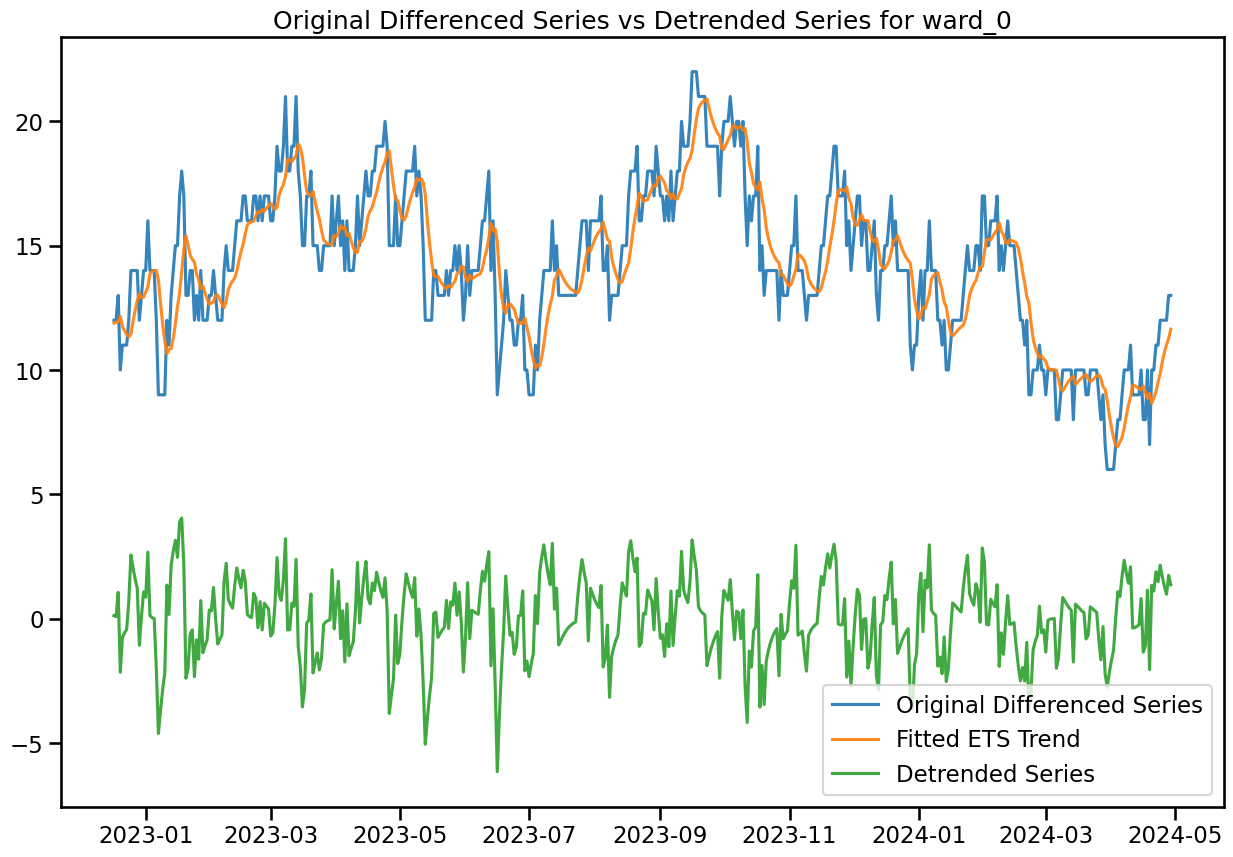

In [21]:
# plot original differenced series in two plots in one graph
plt.figure(figsize=(15, 10))
plt.plot(df_diff.index[-500:], df_diff['ward_0'][-500:], label='Original Differenced Series', color='C0', alpha=0.9)
plt.plot(df_diff.index[-500:], df_diff['ward_0_fitted_ets_trend'][-500:], label='Fitted ETS Trend', color='C1', alpha=0.9)
plt.plot(df_diff.index[-500:], df_diff['ward_0_detrended'][-500:], label='Detrended Series', color='C2', alpha=0.9)
plt.title('Original Differenced Series vs Detrended Series for ward_0')
plt.legend(loc='lower right')

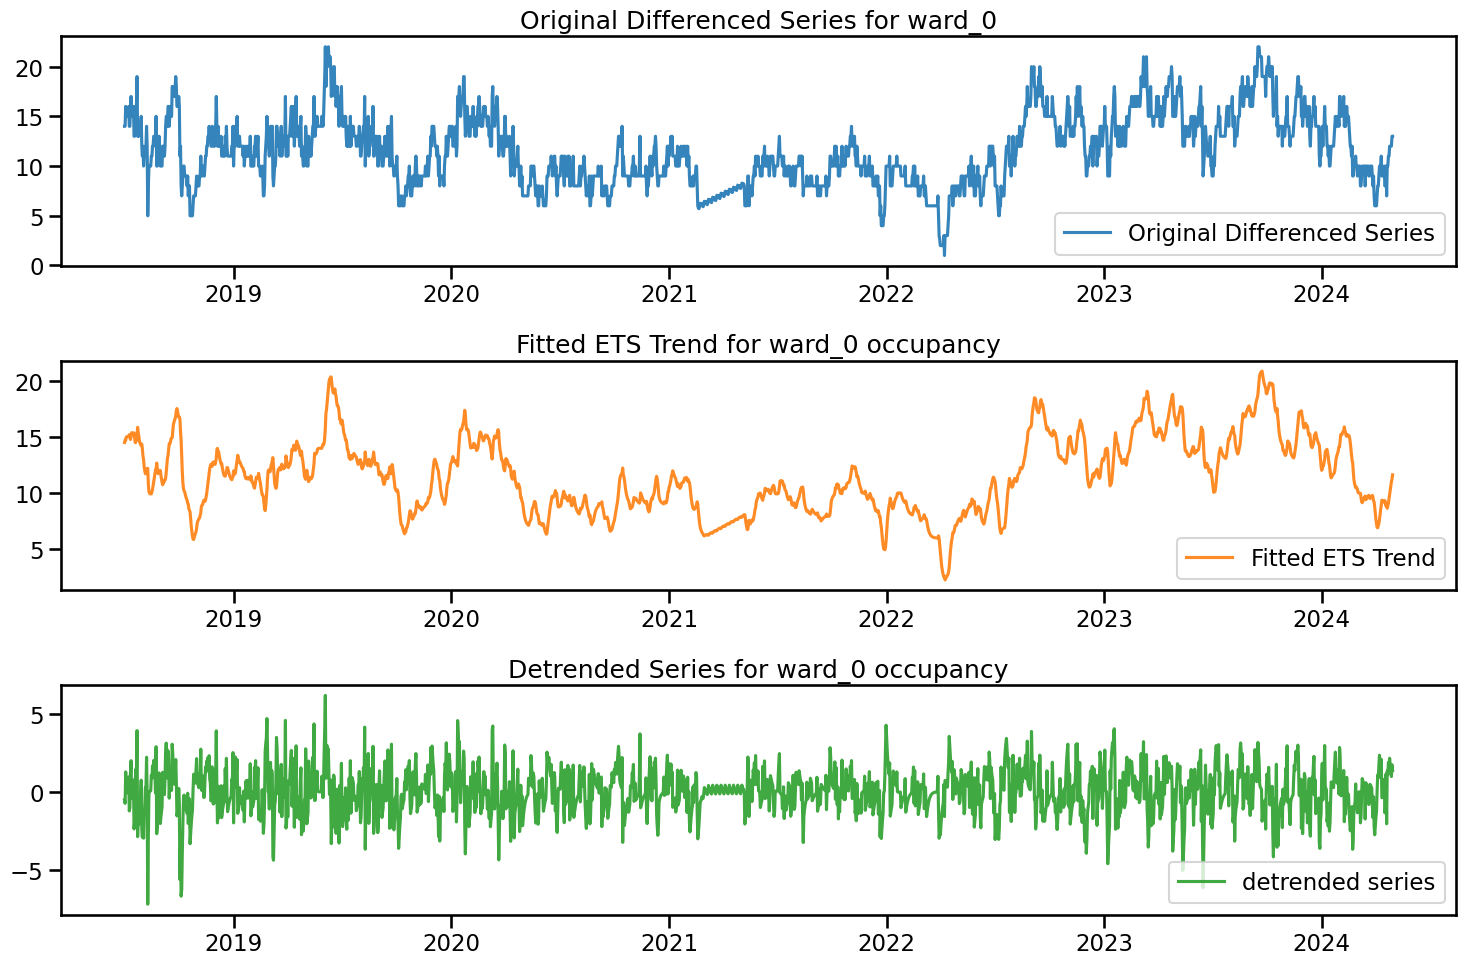

In [22]:
# plot original differenced series in two plots in one graph
fig, axs = plt.subplots(3, 1, figsize=(15, 10))
axs[0].plot(df_diff.index, df_diff['ward_0'], label='Original Differenced Series', color='C0', alpha=0.9)
axs[0].set_title('Original Differenced Series for ward_0')
axs[0].legend(loc = 'lower right')
axs[1].plot(df_diff.index, df_diff['ward_0_fitted_ets_trend'], label='Fitted ETS Trend', color='C1', alpha=0.9)
axs[1].set_title('Fitted ETS Trend for ward_0 occupancy')
axs[1].legend(loc = 'lower right')
axs[2].plot(df_diff.index, df_diff['ward_0_detrended'], label='detrended series', color='C2', alpha=0.9)
axs[2].set_title('Detrended Series for ward_0 occupancy')
axs[2].legend(loc = 'lower right')
plt.tight_layout()

plt.show()


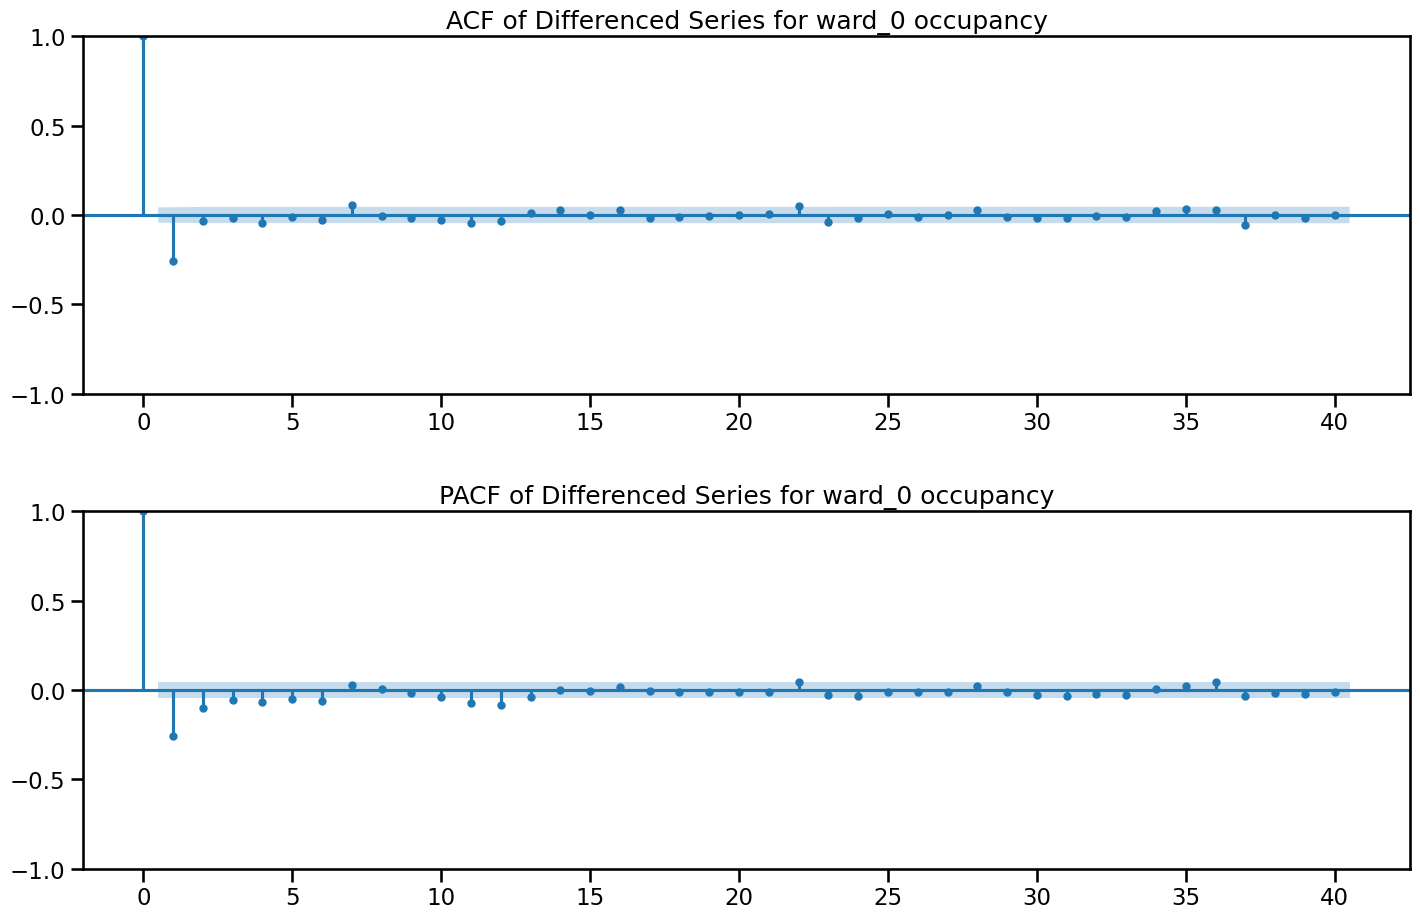

In [83]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
plot_acf(df_diff['ward_0_diff'], lags=40, ax=axes[0])
plot_pacf(df_diff['ward_0_diff'], lags=40, ax=axes[1])
axes[0].set_title('ACF of Differenced Series for ward_0 occupancy')
axes[1].set_title('PACF of Differenced Series for ward_0 occupancy')
plt.tight_layout(pad=2)
plt.show()

## ETS results

In [23]:
# Load from file
with open('model_params/ets_season_param.pkl', 'rb') as f:
    ets_season_param = pickle.load(f)
    
def ets_ward_perf(ward, step_size=13, days_in_test=None):
    if days_in_test is not None:
        df_ = data_prep(ward)[:-days_in_test]
    else:
        df_ = data_prep(ward)
    metrics = [SRMSE, MAE, RMSE, MASE]
    perfmance_ets = {m.__name__: [] for m in metrics}
    tscv = ParametricTimeSeriesSplit(n_splits=30, test_size=30, step_size=step_size)
    for train_index, test_index in tscv.split(df_):
        train, test = df_.iloc[train_index], df_.iloc[test_index]
        y_test = np.array(test[ward])
        fit = ExponentialSmoothing(train[ward],
                                   **ets_season_param[ward][0]).fit(**ets_season_param[ward][1])
        y_forecast = fit.forecast(steps=30)
    
        #Evaluate using the specified metric
        for m in metrics:
            if m in [MASE, SMAE, SRMSE, RMSSE]:
                eval_val = m(y_test, y_forecast, np.array(train[ward]))
            else:
                eval_val = m(y_test, y_forecast)
            perfmance_ets[m.__name__].append(eval_val)
    overall_performance = [[m.__name__, np.mean(perfmance_ets[m.__name__])] for m in metrics]
    overall_performance = pd.DataFrame(overall_performance).rename(columns={0: "eval_metric", 1: "ets"})
    return overall_performance

# ets_pointf_perform = {}
# for w_ in ward_cols_:
#     ets_pointf_perform[w_] = ets_ward_perf(w_)

# # Save to file
# with open('results/ets_pointf_perform.pkl', 'wb') as f:
#     pickle.dump(ets_pointf_perform, f)

# Load from file
with open('results/ets_pointf_perform.pkl', 'rb') as f:
    ets_pointf_perform = pickle.load(f)

In [24]:
ets_pointf_perform["ward_0"]

eval_metric       ets
0       SRMSE  0.309981
1         MAE  3.167916
2        RMSE  3.679475
3        MASE  3.801991

## LR CV results

In [25]:

# Load from file
with open('model_params/best_ward_ets_tk.pkl', 'rb') as f:
    best_ward_ets_tk = pickle.load(f)
# Load from file
with open('model_params/best_ward_ets_forecastk.pkl', 'rb') as f:
    best_ward_ets_forecastk = pickle.load(f)

# ml_best_ward_etsforecast = {col: best_ward_ets_forecastk[col][0] for col in ward_cols_}

# # Save to file
# with open('model_params/ml_best_ward_etsforecast.pkl', 'wb') as f:
#     pickle.dump(ml_best_ward_etsforecast, f)
# Load from file
with open('model_params/ml_best_ward_etsforecast.pkl', 'rb') as f:
    ml_best_ward_etsforecast = pickle.load(f)


# Load from file
with open('model_params/ward_best_forward_lags.pkl', 'rb') as f:
    ward_best_forward_lags = pickle.load(f)
    
def lr_performance(ets_param, step_size=13, test_datasize=None):
    lr_pointf_perform = {}
    for w in ward_cols_:
        k = ets_param[w][1]
        if test_datasize is not None:
            df_ = data_prep_f(ward=w, fourier_k=k, days_in_test=test_datasize)
        else:
            df_ = data_prep_f(ward=w, fourier_k=k)
        lr_model_ets = ml_forecaster(LinearRegression(), lags=ward_best_forward_lags[w], target_col=w,
                                    cat_variables=cat_col_f, trend="ets",
                                ets_params=ets_param[w][0])
        cv_m = cross_validate(model=lr_model_ets, df=df_, cv_split=30, test_size=30,
                            step_size=step_size, metrics=[SRMSE, MAE, RMSE, MASE])
        cv_m.rename(columns={"score": "linearRegression"}, inplace = True)
        lr_pointf_perform[w] = cv_m
    return lr_pointf_perform

# lr_pointf_perform_ = lr_performance()

# with open('results/lr_pointf_perform_.pkl', 'wb') as f:
#     pickle.dump(lr_pointf_perform_, f)


# Load from file
with open('results/lr_pointf_perform_.pkl', 'rb') as f:
    lr_pointf_perform_ = pickle.load(f)

In [ ]:
# lr_pointf_perform_t = lr_performance(best_ward_ets_tk)
lr_pointf_perform_ = lr_performance(best_ward_ets_forecastk)

In [ ]:
# # # Save to file
# with open('results/lr_pointf_perform_.pkl', 'wb') as f:
#     pickle.dump(lr_pointf_perform_, f)
# # Load from file
# with open('results/lr_pointf_perform_.pkl', 'rb') as f:
#     lr_pointf_perform_ = pickle.load(f)

## ML ressults

In [26]:
# Load from file
with open('model_params/ml_best_ward_ets.pkl', 'rb') as f:
    ml_best_ward_ets = pickle.load(f)

# Load from file
with open('model_params/_best_xgb_params.pkl', 'rb') as f:
    _best_xgb_params = pickle.load(f)
# Load from file
with open('model_params/_best_lgb_params.pkl', 'rb') as f:
    _best_lgb_params = pickle.load(f)
with open('model_params/_best_rf_params.pkl', 'rb') as f:
    _best_rf_params = pickle.load(f)
with open('model_params/_best_lasso_params.pkl', 'rb') as f:
    _best_lasso_params = pickle.load(f)


def ml_performance(ets_param, step_size=13, test_datasize=None):
    ml_pointf_perform = {}

    for w in ward_cols_:
        if test_datasize is not None:
            df_ = data_prep(ward=w, days_in_test=test_datasize)
        else:
            df_ = data_prep(w)
        model_param_ = _best_xgb_params[w][0]
        model_lags_ = _best_xgb_params[w][1]
        xgb_model_ets = ml_forecaster(XGBRegressor(**model_param_), lags=model_lags_, target_col=w,
                                    cat_variables=cat_cols, trend="ets",
                                    ets_params=ets_param[w])
        cv_m = cross_validate(model=xgb_model_ets, df=df_, cv_split=30, test_size=30,
                            step_size=step_size, metrics=[SRMSE, MAE, RMSE, MASE])
        cv_m.rename(columns={"score": "XGBoost"}, inplace = True)
        ml_pointf_perform[w] = cv_m

        model_param_ = _best_lgb_params[w][0]
        model_lags_ = _best_lgb_params[w][1]
        lgb_model_ets = ml_forecaster(LGBMRegressor(**model_param_, verbose=-1), lags=model_lags_, target_col=w,
                                    cat_variables=cat_cols, trend="ets",
                                ets_params=ets_param[w])
        cv_m = cross_validate(model=lgb_model_ets, df=df_, cv_split=30, test_size=30,
                            step_size=step_size, metrics=[SRMSE, MAE, RMSE, MASE])
        cv_m.rename(columns={"score": "LightGBM"}, inplace = True)
        ml_pointf_perform[w] = ml_pointf_perform[w].merge(cv_m, left_on="eval_metric", right_on="eval_metric")

        model_param_ = _best_rf_params[w][0]
        model_lags_ = _best_rf_params[w][1]
        rf_model_ets = ml_forecaster(RandomForestRegressor(**model_param_), lags=model_lags_, target_col=w,
                                    cat_variables=cat_cols, trend="ets",
                                ets_params=ets_param[w])
        cv_m = cross_validate(model=rf_model_ets, df=df_, cv_split=30, test_size=30,
                            step_size=step_size, metrics=[SRMSE, MAE, RMSE, MASE])
        cv_m.rename(columns={"score": "RandomForest"}, inplace = True)
        ml_pointf_perform[w] = ml_pointf_perform[w].merge(cv_m, left_on="eval_metric", right_on="eval_metric")


        model_param_ = _best_lasso_params[w][0]
        model_lags_ = _best_lasso_params[w][1]
        lasso_model_ets = ml_forecaster(Lasso(**model_param_), lags=model_lags_, target_col=w,
                                    cat_variables=cat_cols, trend="ets",
                                ets_params=ets_param[w])
        cv_m = cross_validate(model=lasso_model_ets, df=df_, cv_split=30, test_size=30,
                            step_size=step_size, metrics=[SRMSE, MAE, RMSE, MASE])
        cv_m.rename(columns={"score": "Lasso"}, inplace = True)
        ml_pointf_perform[w] = ml_pointf_perform[w].merge(cv_m, left_on="eval_metric", right_on="eval_metric")
        print(f"Completed ML CV for {w}")
    return ml_pointf_perform

In [281]:
ml_pointf_perform_ = ml_performance(ml_best_ward_etsforecast)
# print("forecast_ets done")
# ml_pointf_perform_f = ml_performance(ml_best_ward_ets)

Completed ML CV for ward_0
Completed ML CV for ward_1
Completed ML CV for ward_2
Completed ML CV for ward_3
Completed ML CV for ward_4
Completed ML CV for ward_5
Completed ML CV for ward_6


In [27]:
# with open('results/ml_pointf_perform_.pkl', 'wb') as f:
#     pickle.dump(ml_pointf_perform_, f)

# Load from file
with open('results/ml_pointf_perform_.pkl', 'rb') as f:
    ml_pointf_perform_ = pickle.load(f)

## HMM results

In [27]:
# Load from file
with open('model_params/hmm_best_forward_lags.pkl', 'rb') as f:
    hmm_best_forward_lags = pickle.load(f)

# Load from file
with open('model_params/best_ward_ets_tk.pkl', 'rb') as f:
    best_ward_ets_tk = pickle.load(f)
# Load from file
with open('model_params/best_ward_ets_forecastk.pkl', 'rb') as f:
    best_ward_ets_forecastk = pickle.load(f)

# Load from file
with open('model_params/best_hmm_ets_tks.pkl', 'rb') as f:
    best_hmm_ets_tks = pickle.load(f)

def hmm_performance(ets_param, test_datasize=None):
    hmm_pointf_perform = {}
    for w in ward_cols_:
        k = ets_param[w][1]
        ets_paramshmm = ets_param[w][0]
        hmm_lags = sorted(hmm_best_forward_lags[w][0]["best_lags"])
        s = best_hmm_ets_tks[w][2]

        if test_datasize is not None:
            df_ = data_prep_f(ward=w, fourier_k=k, days_in_test=test_datasize)
        else:
            df_ = data_prep_f(ward=w, fourier_k=k)

        hm_model = MsHmmRegression(n_components=s, target_col=w, cat_variables=cat_col_f, lags=hmm_lags,
                            trend="ets", ets_params=ets_paramshmm, random_state=42, n_iter=300, tol=1e-3)
        fit_df = df_[:-360] # fit on train data only to avoid data leakage
        hm_model.fit_em(fit_df)
        cv_ = hmm_cross_validate(model=hm_model, df=df_, cv_split=30, test_size=30, step_size=13, n_iter=100, metrics=[SRMSE, MAE, RMSE, MASE])
        cv_.rename(columns={"score": "HMM"}, inplace = True)
        hmm_pointf_perform[w] = cv_
        print(f"Completed HMM CV for {w}")
    return hmm_pointf_perform

In [ ]:
hmm_performance_ = hmm_performance(best_ward_ets_forecastk)
hmm_performance_past = hmm_performance(best_hmm_ets_tks)

## all results

In [28]:
# Load from file
with open('results/all_model_points.pkl', 'rb') as f:
    all_model_points = pickle.load(f)

In [90]:
import copy
import statsmodels.api as sm
from scipy.stats import norm, multivariate_normal
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.special import logsumexp

class MsHmmRegression:
    """
    Hidden Markov Model Regression for time series with EM parameter estimation.

    Args:
        n_components (int): Number of hidden states.
        target_col (str): Name of the target variable.
        lag_list (list): List of integer lags to include as features.
        method (str): 'posterior' for soft state assignment, 'viterbi' for hard paths.
        startprob_prior (float): Prior for initial state probabilities.
        transmat_prior (float): Prior for transition matrix.
        ets_params (tuple, optional): A tuple (model_params, fit_params) for exponential smoothing. Ex.g. ({'trend': 'add', 'seasonal': 'add'}, {'damped_trend': True}). If trend is "ets", this will be used.
        change_points (list or None): List of change points for piecewise linear regression to handle trend
        add_constant (bool): Whether to add constant to regressors.
        difference (int or None): Order of differencing to apply to target.
        trend (str or None): Type of trend to remove ('linear', 'ets', etc.). Default is None.
        cat_variables (list or None): List of categorical columns.
        n_iter (int): Maximum number of EM iterations.
        tol (float): Convergence tolerance for EM.
        coefficients (np.ndarray or None): Initial regression coefficients.
        stds (np.ndarray or None): Initial state std deviations.
        init_state (np.ndarray or None): Initial state distribution.
        trans_matrix (np.ndarray or None): Initial transition matrix.
        random_state (int or None): Random seed.
        verbose (bool): Print progress if True.
    """

    def __init__(self, n_components, target_col, lags, method="posterior",
                 startprob_prior=1e3, transmat_prior=1e5, add_constant=True,
                 difference=None, trend=None, ets_params = None, change_points=None,
                 cat_variables=None, lag_transform=None, n_iter=100, tol=1e-6,
                 coefficients=None, stds=None, init_state=None, trans_matrix=None,
                 box_cox=False, lamda=None, box_cox_biasadj=False, season_diff=None,
                 ridge=1e-5, var_floor=1e-5, 
                 random_state=None, verbose=False):
        self.N = n_components
        self.target_col = target_col
        self.diff = difference
        self.cons = add_constant
        self.cat_variables = cat_variables
        # lags must be a list of integers or an integer
        if not isinstance(lags, (int, list)):
            raise ValueError("Lags must be an integer or a list of integers.")

        self.lags = [i for i in range(1, lags + 1)] if isinstance(lags, int) else lags
        self.method = method
        self.box_cox = box_cox
        self.lamda = lamda
        self.biasadj = box_cox_biasadj
        self.trend = trend
        if ets_params is not None:
            self.ets_model = ets_params[0]
            self.ets_fit = ets_params[1]
        else:
            self.ets_model = None
            self.ets_fit = None
        
        self.cps = change_points
        self.season_diff = season_diff
        self.lag_transform = lag_transform
        self.iter = n_iter
        self.tol = tol
        self.ridge = ridge
        self.var_floor = var_floor
        self.verb = verbose


        # RNG for reproducibility
        self.rng = np.random.default_rng(random_state)
        if init_state is None:
            self.sp = startprob_prior
            self.alpha_p = np.repeat(self.sp, self.N)
            self.pi = self.rng.dirichlet(self.alpha_p) # Initial state probabilities using Dirichlet distribution
        else:
            self.pi = np.array(init_state)
        if trans_matrix is None:
            self.tm = transmat_prior
            self.alpha_t = np.repeat(self.tm, self.N) # 
            self.A = self.rng.dirichlet(self.alpha_t, size=self.N)
        else:
            self.A = np.array(trans_matrix)

        self.coeffs = coefficients
        self.stds = stds


    def data_prep(self, df):
        """
        Prepare the data: encode categoricals, add lags, trend, differencing.
        """
        dfc = df.copy()
        # Categorical variable encoding
        if self.cat_variables is not None:
            # if self.target_encode ==True:
            #     for col in self.cat_variables:
            #         encode_col = col+"_target_encoded"
            #         dfc[encode_col] = kfold_target_encoder(dfc, col, self.target_col, 36)
            #     self.df_encode = dfc.copy()
            #     dfc = dfc.drop(columns = self.cat_variables)
            #     # If target encoding is not used, convert categories to dummies    

            # else:
            for col, cat in self.cat_var.items():
                dfc[col] = dfc[col].astype('category')
                # Set categories for categorical columns
                dfc[col] = dfc[col].cat.set_categories(cat)
            dfc = pd.get_dummies(dfc, dtype=np.float64)

            for i in self.drop_categ:
                dfc.drop(list(dfc.filter(regex=i)), axis=1, inplace=True)
        
        if self.target_col in dfc.columns:
            # Apply Box–Cox transformation if specified
            if self.box_cox:
                self.is_zero = np.any(np.array(dfc[self.target_col]) < 1) # check for zero or negative values
                trans_data, self.lamda = box_cox_transform(x=dfc[self.target_col],
                                                        shift=self.is_zero,
                                                        box_cox_lmda=self.lamda)
                dfc[self.target_col] = trans_data

            if self.trend is not None:
                self.len = len(dfc)
                self.target_orig = dfc[self.target_col] # Store original values for later use during forecasting
                if self.trend == "linear":
                    # self.lr_model = LinearRegression().fit(np.arange(self.len).reshape(-1, 1), self.target_orig)
                    # dfc[self.target_col] = dfc[self.target_col] - self.lr_model.predict(np.arange(self.len).reshape(-1, 1))
                    if self.cps is not None:
                        trend, self.lr_model = lr_trend_model(self.target_orig, breakpoints=self.cps, type='piecewise')
                    else:
                        trend, self.lr_model = lr_trend_model(self.target_orig)
                    dfc[self.target_col] = dfc[self.target_col] - trend
                if self.trend == "ets":
                    self.ets_model_fit = ExponentialSmoothing(self.target_orig, **self.ets_model).fit(**self.ets_fit)
                    dfc[self.target_col] = dfc[self.target_col] - self.ets_model_fit.fittedvalues.values


            # Apply differencing if specified
            if self.diff is not None or self.season_diff is not None:
                self.orig = dfc[self.target_col].tolist()
                if self.diff is not None:
                    dfc[self.target_col] = np.diff(dfc[self.target_col], n=self.diff,
                                                prepend=np.repeat(np.nan, self.diff))
                if self.season_diff is not None:
                    self.orig_d = dfc[self.target_col].tolist()
                    dfc[self.target_col] = seasonal_diff(dfc[self.target_col], self.season_diff)

            # Create lag features based on lags parameter
            if self.lags is not None:
                for lag in self.lags:
                    dfc[f"{self.target_col}_lag_{lag}"] = dfc[self.target_col].shift(lag)
            # Create additional lag transformations if specified
            if self.lag_transform is not None:
                for func in self.lag_transform:
                    if isinstance(func, (expanding_std, expanding_mean)):
                        dfc[f"{func.__class__.__name__}_shift_{func.shift}"] = func(dfc[self.target_col])
                    elif isinstance(func, expanding_quantile):
                        dfc[f"{func.__class__.__name__}_shift_{func.shift}_q{func.quantile}"] = func(dfc[self.target_col])
                    elif isinstance(func, rolling_quantile):
                        dfc[f"{func.__class__.__name__}_{func.window_size}_shift_{func.shift}_q{func.quantile}"] = func(dfc[self.target_col])
                    else:
                        dfc[f"{func.__class__.__name__}_{func.window_size}_shift_{func.shift}"] = func(dfc[self.target_col])
                        
            self.df = dfc.dropna()
            self.X = self.df.drop(columns=self.target_col)
            self.y = self.df[self.target_col]
            if self.cons:
                self.X = sm.add_constant(self.X)
            self.col_names = self.X.columns.tolist() if hasattr(self.X, 'columns') else [f"x{i}" for i in range(self.X.shape[1])]
            self.X = np.array(self.X)
            self.y = np.array(self.y)
            self.T = len(self.y)
            if self.coeffs is None or self.stds is None:
                # Initial fit: use unweighted least squares for all states
                coeffs = []
                stds = []
                for i in range(self.N):
                    # Least squares fit
                    coeff_i = np.linalg.lstsq(self.X, self.y, rcond=None)[0]
                    coeffs.append(coeff_i)
                    y_pred = self.X @ coeff_i
                    resid = self.y - y_pred
                    var_i = np.mean(resid ** 2)
                    stds.append(np.sqrt(var_i))
                self.coeffs = np.row_stack(coeffs)
                self.stds = np.array(stds)

        else:
            return dfc.dropna()


    def compute_coeffs(self, w_floor=1e-5):

        # Update regression coefficients and stds for each state

        # If posterior probabilities are shorter than the number of observations, make self.X and self.y same length visa vis make posterier same as self.X and self.y length
        if self.posterior.shape[1] < self.X.shape[0]:
            # Truncate self.X and self.y to match the length of self.posterior[i]
            self.X = self.X[:self.posterior.shape[1]]
            self.y = self.y[:self.posterior.shape[1]]
        if self.posterior.shape[1] > self.X.shape[0]:
            # Truncate self.posterior to match the length of self.X and self.y
            self.posterior = self.posterior[:, -self.X.shape[0]:]

        coeffs = []
        stds = []
        X = self.X
        for s in range(self.N):
            # Add floor so state isn’t “killed”
            w = self.posterior[s] + w_floor
            w /= w.sum()
            sw = np.sqrt(w)
            Xw = X * sw[:, None]
            yw = self.y * sw
            XtX = Xw.T @ Xw + self.ridge*np.eye(X.shape[1])
            Xty = Xw.T @ yw
            beta_s = np.linalg.lstsq(XtX, Xty, rcond=None)[0]
            coeffs.append(beta_s)
            resid = self.y - X @ beta_s
            var_s = (w * resid**2).sum() / max((w.sum()-beta_s.shape[0]), 1.0)
            stds.append(np.sqrt(max(var_s, self.var_floor)))
        self.coeffs = np.row_stack(coeffs)
        self.stds = np.array(stds)


# Hidden Markov Model with Vector Autoregressive (VAR)

    def _log_emissions(self):
        # logB[s,t] = log p(y_t | state s)
        N, T = self.N, self.T
        logB = np.empty((N, T))
        self.fitted = np.empty((N, T))
        # self.compute_coeffs()
        for s in range(N):
            mu = self.X @ self.coeffs[s]           # (T,)
            self.fitted[s, :] = mu
            logB[s, :] = norm.logpdf(self.y, loc=mu, scale=self.stds[s])
        return logB

    def _e_step_log(self):
        N, T = self.N, self.T
        logA  = np.log(self.A + 1e-300)
        logpi = np.log(self.pi + 1e-300)
        logB  = self._log_emissions()

        # Forward
        log_alpha = np.empty((N, T))
        log_alpha[:, 0] = logpi + logB[:, 0]
        for t in range(1, T):
            # log_alpha[:,t] = logB[:,t] + logsumexp_i( log_alpha[i,t-1] + logA[i,:] )
            log_alpha[:, t] = logB[:, t] + logsumexp(log_alpha[:, t-1][:, None] + logA, axis=0)

        # Log-likelihood
        loglik = logsumexp(log_alpha[:, -1])

        # Backward
        log_beta = np.full((N, T), 0.0)
        for t in range(T-2, -1, -1):
            # log_beta[:,t] = logsumexp_j( logA + logB[:,t+1] + log_beta[:,t+1] , axis=1 )
            log_beta[:, t] = logsumexp(logA + (logB[:, t+1] + log_beta[:, t+1])[None, :], axis=1)

        # Gamma
        log_gamma = log_alpha + log_beta - loglik
        # normalize per time to kill rounding; columns sum to 1 after exp
        log_gamma -= logsumexp(log_gamma, axis=0)
        gamma = np.exp(log_gamma)

        # Xi
        log_xi = np.empty((N, N, T-1))
        for t in range(T-1):
            tmp = log_alpha[:, t][:, None] + logA + (logB[:, t+1] + log_beta[:, t+1])[None, :]
            tmp -= logsumexp(tmp)      # normalize this slice
            log_xi[:, :, t] = tmp
        xi = np.exp(log_xi)

        # print("logB min/max:", np.min(logB), np.max(logB))
        # print("Any NaN in logB?", np.any(np.isnan(logB)))
        # print("Any Inf in logB?", np.any(np.isinf(logB)))
        # sanity checks (soft)
        assert np.allclose(gamma.sum(axis=0), 1.0, atol=1e-8)
        assert np.allclose(xi.sum(axis=(0,1)), 1.0, atol=1e-8)

        self.log_forward  = log_alpha
        self.log_backward = log_beta
        self.posterior    = gamma
        self.loglik       = loglik
        return loglik, gamma, xi


    def _m_step(self, gamma, xi):
        numer = xi.sum(axis=2)                         # (N,N)
        denom = gamma[:, :-1].sum(axis=1, keepdims=True)  # (N,1)
        A = numer / (denom + 1e-12)
        A = np.maximum(A, 1e-12)
        A /= A.sum(axis=1, keepdims=True)
        self.A = A
        self.pi = gamma[:, 0] / gamma[:, 0].sum()
        self.compute_coeffs() 


    def EM(self):
        loglik, gamma, xi = self._e_step_log()
        self._m_step(gamma, xi)
        self.LL = loglik
        # return loglik
        
    def fit_em(self, df_train):
        """
        Run EM iterations until convergence (log-domain version).
        """

        # Handle categorical variable encoding
        if self.cat_variables is not None:
            self.cat_var = {c: sorted(df_train[c].drop_duplicates().tolist(), key=lambda x: str(x))
                            for c in self.cat_variables}
            self.drop_categ = [sorted(df_train[col].drop_duplicates().tolist(), key=lambda x: str(x))[0]
                               for col in self.cat_variables]
        self.data_prep(df_train)

        prev_ll = -np.inf
        # store intermediate log-likelihoods
        self.log_likelihoods = []
        for it in range(self.iter):
            # loglik, gamma, xi = self._e_step_log()
            # self._m_step(gamma, xi)
            self.EM()
            if self.verb:
                print(f"Iter {it}: loglik={self.LL:.4f}")
            if it > 10:
                if abs(self.LL - prev_ll) < self.tol:
                    if self.verb:
                        print("Converged.")
                    break
            self.log_likelihoods.append(self.LL)
            prev_ll = self.LL
        return self.LL

    def fit(self, df, n_iter=1):
        """
        Refit the HMM regression model on new training data (log-domain version).
        """
        if n_iter < 1:
            raise ValueError("n_iter must be at least 1.")
        
        self.data_prep(df)
        if n_iter > 1:
            prev_ll = self.LL
            for _ in range(n_iter):
                self.EM()
                if abs(self.LL - prev_ll) < self.tol:
                    break
                else:
                    prev_ll = self.LL
        else:
            self.EM()

        return self.LL
    
    def predict_states(self):
        return np.argmax(self.posterior, axis=0)
    def predict_proba(self):
        return self.posterior
    
    # AIC computation    
    @property
    def AIC(self):
        k = self.N * self.X.shape[1] + self.N ** 2 + self.N - 1
        return 2 * k - 2 * self.LL

    @property
    def BIC(self):
        
        k = self.N * self.X.shape[1] + self.N ** 2 + self.N - 1
        
        n = self.T  # effective number of observations
        return -2 * self.LL + k * np.log(n)

    def copy(self):
        return copy.deepcopy(self)

    def forecast(self, H, exog=None):
        """
        Forecast H periods ahead using fitted HMM regression (log-domain version), with advanced post-processing.

        Handles:
        - Trend re-adjustment (linear/ETS)
        - Seasonal differencing reversal
        - Regular differencing reversal
        - Box-Cox back-transform
        - Exogenous variables
        - Lag transformations
        """
        y_list = self.y.tolist()
        forecasts_ = []
        N = self.N

        # Prepare exogenous future regressors if provided
        if exog is not None:
            if self.cons:
                if exog.shape[0] == 1:
                    exog.insert(0, 'const', 1)
                else:
                    exog = sm.add_constant(exog)
            exog = np.array(self.data_prep(exog))


        # Init with last forward distribution (in log)
        log_forward_last = self.log_forward[:, -1]
        logA = np.log(self.A + 1e-300)

        # Forward
        log_alpha = np.empty((N, H))
        log_alpha[:, 0] = logsumexp(log_forward_last[:, None] + logA, axis=0)
        for t in range(1, H):
            # log_alpha[:,t] = logB[:,t] + logsumexp_i( log_alpha[i,t-1] + logA[i,:] )
            log_alpha[:, t] = logsumexp(log_alpha[:, t-1][:, None] + logA, axis=0)

        log_alpha -= logsumexp(log_alpha, axis=0)
        self.forecast_forward = np.exp(log_alpha)
        self.state_forecasts = np.argmax(self.forecast_forward, axis=0)
        #per state forecasts
        self.forecast_ps = np.zeros((N, H))

        # Prepare for trend adjustment
        # This assumes you stored original target (pre-trend removal) in self.target_orig
        if hasattr(self, 'target_orig') and self.trend is not None:
            if self.trend == "linear":
                # future_time = np.arange(len(self.target_orig), len(self.target_orig) + H).reshape(-1, 1)
                # trend_forecast = np.array(self.lr_model.predict(future_time))
                trend_forecast= forecast_trend(model = self.lr_model, H=H, start=self.len, breakpoints=self.cps)
            elif self.trend == "ets":
                trend_forecast = np.array(self.ets_model_fit.forecast(H))

        for t in range(H):
            if exog is not None:
                exo_inp = exog[t].tolist()
            else:
                exo_inp = [1] if self.cons else []
            lags = [y_list[-l] for l in self.lags]
            transform_lag = []
            if self.lag_transform is not None:
                series_array = np.array(y_list)
                for func in self.lag_transform:
                    transform_lag.append(func(series_array, is_forecast=True).to_numpy()[-1])
            inp = np.array(exo_inp + lags + transform_lag)

            state_preds = np.zeros(N)
            for j in range(N):
                mu = np.dot(self.coeffs[j], inp)
                state_preds[j] = mu
            self.forecast_ps[:, t] = state_preds

            # normalize to probabilities

            # normalize to probabilities
            pred_w = np.sum(self.forecast_forward[:, t] * state_preds)
            forecasts_.append(pred_w)
            y_list.append(pred_w)

            # log_forward_last = log_f_t.copy()

        forecasts = np.array(forecasts_)

        if self.trend is not None:
            forecasts += trend_forecast
            self.forecast_ps += trend_forecast

        # --- Revert seasonal differencing if applied ---
        if self.season_diff is not None:
            forecasts = invert_seasonal_diff(self.orig_d, forecasts, self.season_diff)
            # Also revert seasonal differencing for per state forecasts
            for s in range(self.N):
                self.forecast_ps[s] = invert_seasonal_diff(self.orig_d, self.forecast_ps[s], self.season_diff)

        # --- Revert regular differencing if applied ---
        if self.diff is not None:
            forecasts = undiff_ts(self.orig, forecasts, self.diff)
            # Also revert differencing for per state forecasts
            for s in range(self.N):
                self.forecast_ps[s] = undiff_ts(self.orig, self.forecast_ps[s], self.diff)

        # --- Box-Cox back-transform if applied ---
        if self.box_cox:
            forecasts = back_box_cox_transform(
                y_pred=forecasts, lmda=self.lamda,
                shift=self.is_zero, box_cox_biasadj=self.biasadj
            )
            for s in range(self.N):
                self.forecast_ps[s] = back_box_cox_transform(
                    y_pred=self.forecast_ps[s], lmda=self.lamda,
                    shift=self.is_zero, box_cox_biasadj=self.biasadj
                )

        return forecasts

In [100]:
k = best_ward_ets_forecastk['ward_0'][1]
ets_paramshmm = best_ward_ets_forecastk['ward_0'][0]
hmm_lags = sorted(hmm_best_forward_lags['ward_0'][0]["best_lags"])
s = best_hmm_ets_tks['ward_0'][2]

df_ = data_prep_f(ward='ward_0', fourier_k=k)

train_size = len(occup_train_clean)
fit_df = df_[:train_size] # fit on train data only to avoid data leakage
test_df = df_[train_size:train_size+30]

hm_model = MsHmmRegression(n_components=s, target_col="ward_0", cat_variables=cat_col_f, lags=hmm_lags,
                    trend="ets", ets_params=ets_paramshmm, random_state=42, var_floor=1e-1,
                      n_iter=300, tol=1e-3)
hm_model.fit_em(fit_df)

np.float64(-2944.4438506327806)

In [85]:
hmm_cross_validate(model=hm_model, df=df_, cv_split=30, test_size=30, step_size=13, n_iter=100, metrics=[SRMSE, MAE, RMSE, MASE])

eval_metric     score
0       SRMSE  0.270739
1         MAE  2.757161
2        RMSE  3.208337
3        MASE  3.311781

In [101]:
hmm_cross_validate(model=hm_model, df=df_, cv_split=30, test_size=30, step_size=13, n_iter=100, metrics=[SRMSE, MAE, RMSE, MASE])

eval_metric     score
0       SRMSE  0.271404
1         MAE  2.766366
2        RMSE  3.215240
3        MASE  3.323389

In [99]:
hm_model.stds

array([1.39380279, 0.1       ])

In [ ]:
# perf_results = {"avg": [], "state_0": [], "state_1": []}
# for i in range(1, 120):
#     dft = df_[:train_size+i] # fit on train data only to avoid data leakage
#     test_dft = df_[train_size+i:train_size+i+30]
#     hm_model.fit(dft, n_iter=100)
#     avg_forecast = hm_model.forecast(30, test_dft.drop(columns=["ward_0"]))
#     s0_forecast = hm_model.forecast_ps[0]
#     s1_forecast = hm_model.forecast_ps[1]
#     SRMSE_avg = SRMSE(np.array(test_dft["ward_0"]), avg_forecast, np.array(dft["ward_0"]))
#     SRMSE_s0 = SRMSE(np.array(test_dft["ward_0"]), s0_forecast, np.array(dft["ward_0"]))
#     SRMSE_s1 = SRMSE(np.array(test_dft["ward_0"]), s1_forecast, np.array(dft["ward_0"]))
#     perf_results["avg"].append(SRMSE_avg)
#     perf_results["state_0"].append(SRMSE_s0)
#     perf_results["state_1"].append(SRMSE_s1)
#     # print(f"Completed rolling forecast and evaluation for rol {i}")
# pd.DataFrame(perf_results).mean()


In [77]:
# fit_df["ward_0"][-700:].hist(bins=15, figsize=(10, 5))
# plt.title("Distribution of ward_0 occupancy - last 700 days in training data")
# plt.xlabel("Occupancy")
# plt.ylabel("Frequency")
# plt.show()

In [36]:
# with open('quarto_result/ward_0_hmm_model.pkl', 'wb') as f:
#     pickle.dump(ward_0_hmm_model, f)

# Load from file
with open('quarto_result/ward_0_hmm_model.pkl', 'rb') as f:
    ward_0_hmm_model = pickle.load(f)

In [31]:
tp = pd.DataFrame(hm_model.A).round(3)
tp.index = [f"State {i+1}" for i in range(tp.shape[0])]
tp.columns = [f"State {i+1}" for i in range(tp.shape[1])]
tp

State 1  State 2
State 1    0.666    0.334
State 2    0.487    0.513

In [34]:
tp.reset_index()

index  State 1  State 2
0  State 1    0.666    0.334
1  State 2    0.487    0.513

In [56]:
stds = pd.DataFrame(hm_model.stds).round(2).T
# change row name to standard deviation
stds = stds.rename(index={0: "standard deviations"})
stds.columns = ["State 0", "State 1"]

In [30]:
stds

NameError: name 'stds' is not defined

In [40]:
state_probs_train = hm_model.predict_proba()
state_predict_train = hm_model.predict_states()

In [60]:
pd.Series(state_predict_train[-365:]).value_counts(normalize=True)

0    0.578082
1    0.421918
Name: proportion, dtype: float64

In [63]:
state_predict_train[-10:]

array([0, 1, 0, 1, 0, 1, 1, 1, 0, 1])

In [ ]:
# Load from file
with open('quarto_result/ward_0_hmm_model.pkl', 'rb') as f:
    ward_0_hmm_model = pickle.load(f)

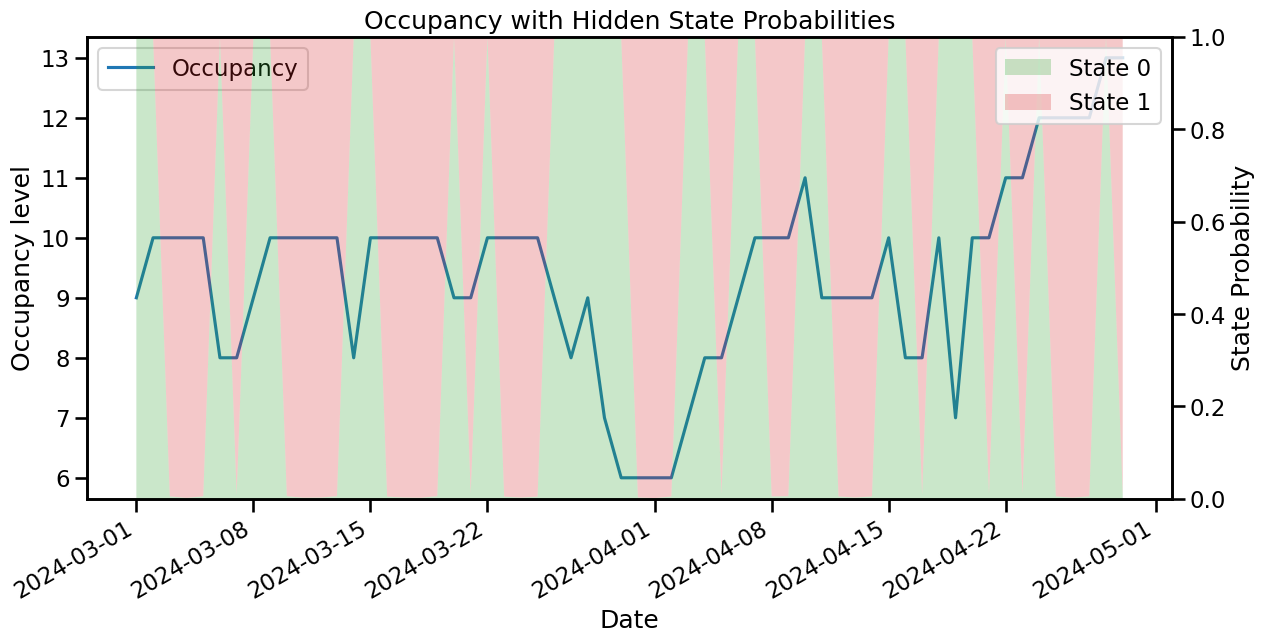

In [36]:
import matplotlib.pyplot as plt
my_series = fit_df[-2074:]["ward_0"]

fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot the time series
ax1.plot(my_series.index[-60:], my_series.values[-60:], label="Occupancy", color="C0")
# ax1.plot(fit_df.index, fit_df["forecast"], label="Occupancy", color="C3", linestyle='--')
# ax1.plot(vis_data.index, vis_data["Discharges"], label="Discharges", color="C1")
ax1.set_ylabel("Occupancy level")
ax1.set_xlabel("Date")
ax1.legend(loc="upper left")

# Overlay probabilities as stacked area
ax2 = ax1.twinx()
ax2.stackplot(my_series.index[-60:],
              state_probs_train[0][-60:], 
              state_probs_train[1][-60:],
              labels=['State 0', 'State 1', 'State 2'], 
              alpha=0.25, colors=['C2','C3', 'C4'])

ax2.set_ylabel("State Probability")
ax2.set_ylim(0, 1)
ax2.legend(loc="upper right")

plt.title("Occupancy with Hidden State Probabilities")
plt.setp(ax1.get_xticklabels(), rotation=30, ha="right")  # <--- Add this line
plt.show()

In [37]:
# Load from file
with open('results/hmm_conforms.pkl', 'rb') as f:
    hmm_conforms = pickle.load(f)

In [39]:
df_ = data_prep_f('ward_0', best_hmm_ets_tks["ward_0"][1])
dfml = data_prep('ward_0')

train_size = len(occup_train_clean)
train_df = df_[:train_size] # fit on train data only to avoid data leakage
test_df = df_[train_size:train_size+30]

train_dfml = dfml[:train_size] # fit on train data only to avoid data leakage
test_dfml = dfml[train_size:train_size+30]

pi_hmm = hmm_conforms["ward_0"].generate_prediction_intervals(train_df, test_df.drop(columns=["ward_0"]))

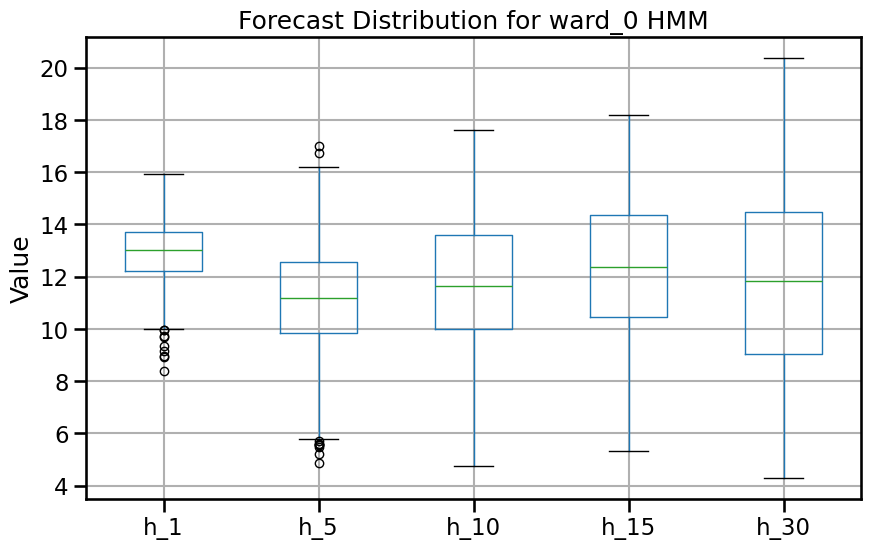

In [40]:
plt.figure(figsize=(10, 6))
hmm_conforms["ward_0"].dist[['h_1', 'h_5', 'h_10', 'h_15', 'h_30']].boxplot()
plt.title("Forecast Distribution for ward_0 HMM")
plt.ylabel("Value")
plt.show()

In [47]:
conf_cols =[hmm_conforms["ward_0"].dist.columns[-i] for i in range(1, 31)]

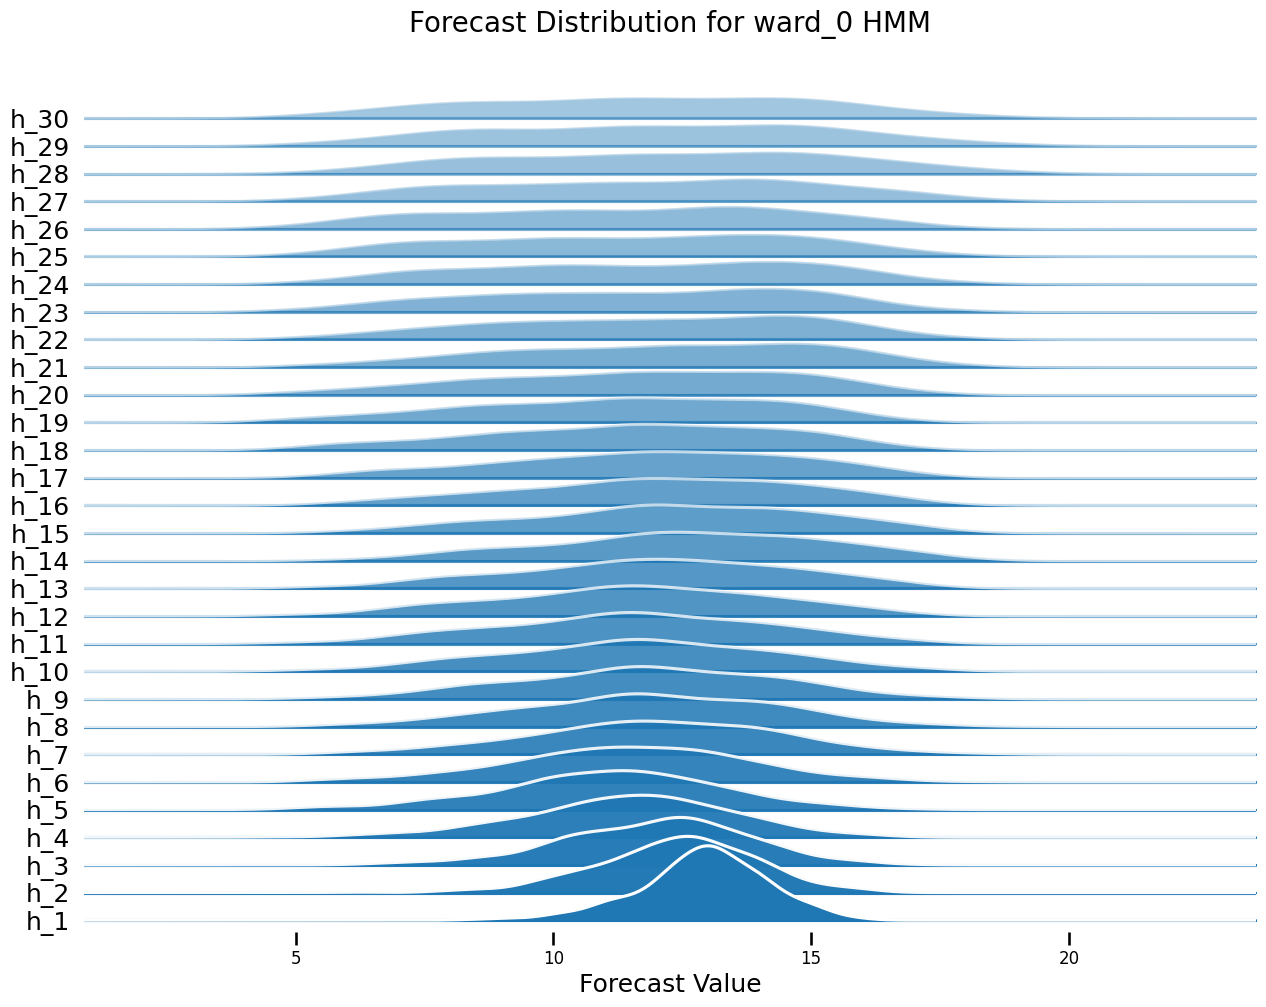

In [ ]:
from joypy import joyplot
dfj = hmm_conforms["ward_0"].dist
conf_cols =[hmm_conforms["ward_0"].dist.columns[-i] for i in range(1, 31)]
joyplot(
    data=dfj, 
    column=conf_cols,  # columns to plot
    overlap=0.6,  # overlap between plots
    figsize=(13, 10),
    fade = True,
    linecolor = "white"
)
plt.yticks(fontsize=8)
plt.xticks(fontsize=12)
plt.title("Forecast Distribution for ward_0 HMM", fontsize=20)
plt.xlabel("Forecast Value")
plt.ylabel("Horizon")
plt.show();

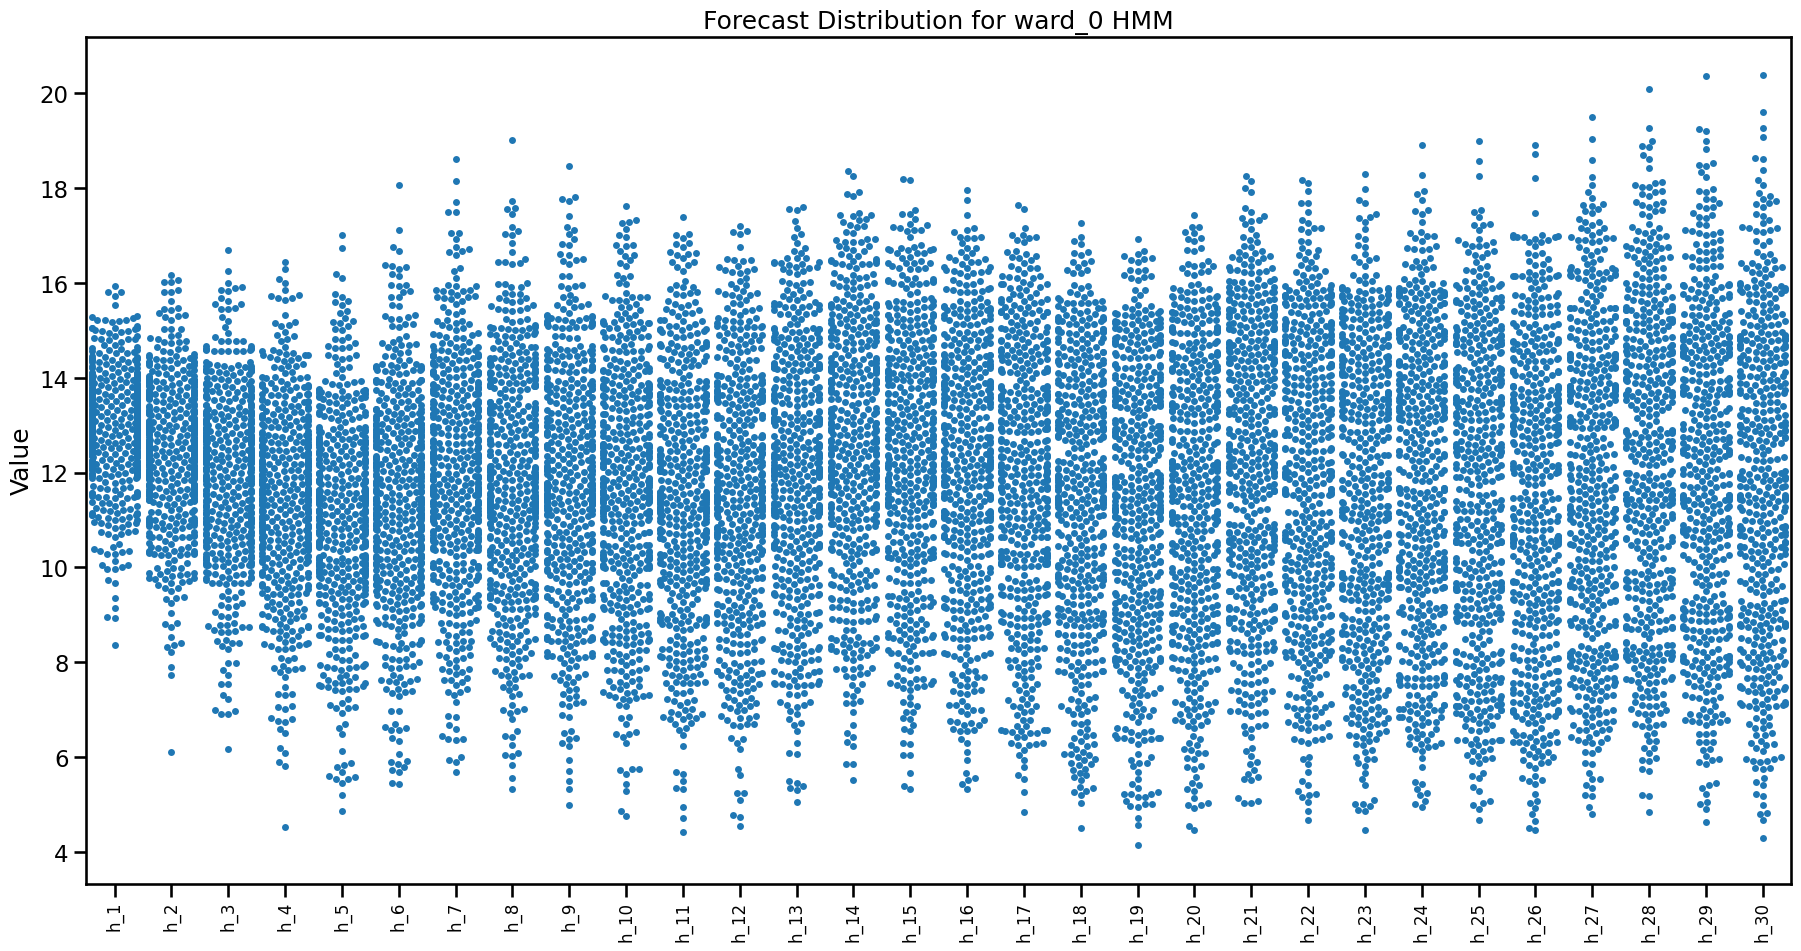

In [82]:
plt.figure(figsize=(22, 11))
palette = sns.color_palette("Blues_r", n_colors=len(hmm_conforms["ward_0"].dist.columns))
sns.swarmplot(data=hmm_conforms["ward_0"].dist, color = "C0")
plt.xticks(rotation=90, fontsize=12)
plt.title("Forecast Distribution for ward_0 HMM")
plt.ylabel("Value")
plt.show()

In [ ]:
train_size = len(occup_train_clean)
occup_test
forecasts = []
state_probs_list = []
state_forecasts = []
fit_df = df_[:train_size]
test_target = df_["ward_0"][train_size:].to_frame()
test_df = df_[train_size:train_size+30].drop(columns=["ward_0"])
hm_model.fit(fit_df, n_iter=100)
y_forecast = hm_model.forecast(30, test_df).tolist()

forecasts.extend(y_forecast)
state_seq = hm_model.state_forecasts.tolist()
state_forecasts.extend(state_seq)

log_alpha = hm_model.forecast_forward
state_probs_list.append(log_alpha)

H = 30
train_size += H


while train_size < len(df_):
    # Prepare fit (training) data
    fit_df = df_[:train_size]
    
    # Determine test (forecast) window, handle edge case for final window
    end_idx = min(train_size + H, len(df_))
    test_df = df_[train_size:end_idx].drop(columns=["ward_0"])
    current_H = end_idx - train_size  # May be less than 30 at the end

    # Fit and forecast
    hm_model.fit(fit_df, n_iter=100)
    y_forecast = hm_model.forecast(current_H, test_df).tolist()
    forecasts.extend(y_forecast)

    state_seq = hm_model.state_forecasts.tolist()
    state_forecasts.extend(state_seq)

    log_alpha = hm_model.forecast_forward
    state_probs_list.append(log_alpha)

    # Advance the training window
    train_size += H

In [89]:
state_probs = np.concatenate(state_probs_list, axis=1) 

In [39]:
point = hm_model.forecast(30, test_df.drop(columns=["ward_0"]))
hm_model.forecast_ps[0]

array([12.7747301 , 12.42390154, 12.08441653, 11.58121551, 11.28040762,
       11.91556   , 12.42665751, 11.88207655, 11.81470847, 11.49832214,
       11.24935295, 11.02136809, 11.65642169, 12.26621221, 11.68740357,
       11.4643657 , 11.30317984, 10.82195942, 10.74693816, 11.26028151,
       11.95867959, 11.31297098, 11.05599206, 11.20779446, 10.7636878 ,
       10.47003598, 11.21341562, 11.64605447, 11.04578202, 10.8698587 ])

In [42]:
fs = hm_model.forecast_forward

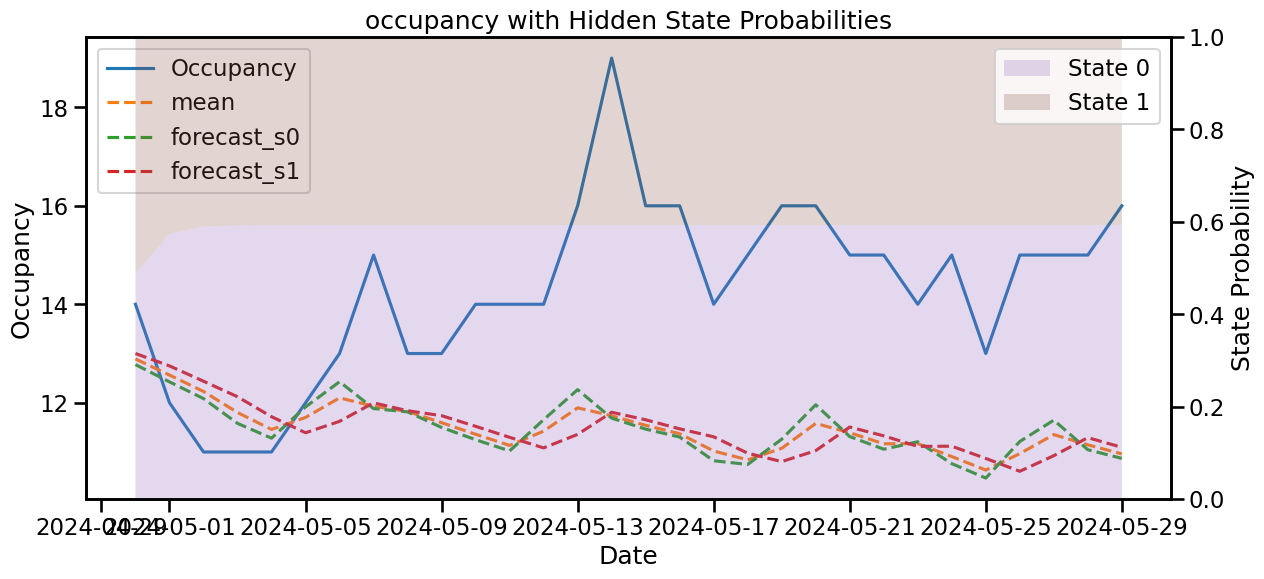

In [45]:
import matplotlib.pyplot as plt
my_series = test_df["ward_0"]

fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot the time series
ax1.plot(test_df.index, my_series.values, label="Occupancy", color="C0")
ax1.plot(test_df.index, point, label="mean", color="C1", linestyle='--')
ax1.plot(test_df.index, hm_model.forecast_ps[0], label="forecast_s0", color="C2", linestyle='--')
ax1.plot(test_df.index, hm_model.forecast_ps[1], label="forecast_s1", color="C3", linestyle='--')
# ax1.plot(vis_data.index, vis_data["Discharges"], label="Discharges", color="C1")
ax1.set_ylabel("Occupancy")
ax1.set_xlabel("Date")
ax1.legend(loc="upper left")

# Overlay probabilities as stacked area
ax2 = ax1.twinx()
ax2.stackplot(my_series.index,
              fs[0], 
              fs[1],
              labels=['State 0', 'State 1'], 
              alpha=0.25, colors=['C4','C5'])

ax2.set_ylabel("State Probability")
ax2.set_ylim(0, 1)
ax2.legend(loc="upper right")

plt.title("occupancy with Hidden State Probabilities")
plt.show()

In [99]:
test_target["forecast"] = forecasts

In [98]:
test_target

ward_0
Date              
2024-04-30    14.0
2024-05-01    12.0
2024-05-02    11.0
2024-05-03    11.0
2024-05-04    11.0
...            ...
2025-04-20    19.0
2025-04-21    20.0
2025-04-22    18.0
2025-04-23    18.0
2025-04-24    18.0

[360 rows x 1 columns]

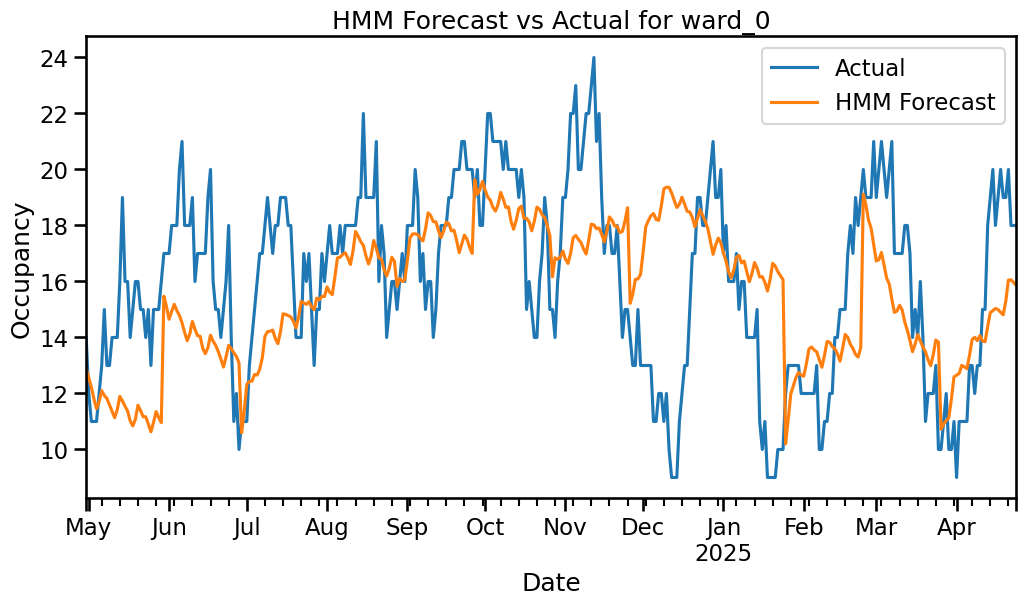

In [80]:
test_target.plot(figsize=(12, 6))
plt.title("HMM Forecast vs Actual for ward_0")
plt.xlabel("Date")
plt.ylabel("Occupancy")
plt.legend(["Actual", "HMM Forecast"])
plt.show()  


In [82]:
test_target.mean()

ward_0      16.041667
forecast    15.542527
dtype: float64

## Decomposition

In [ ]:
occup_train_clean

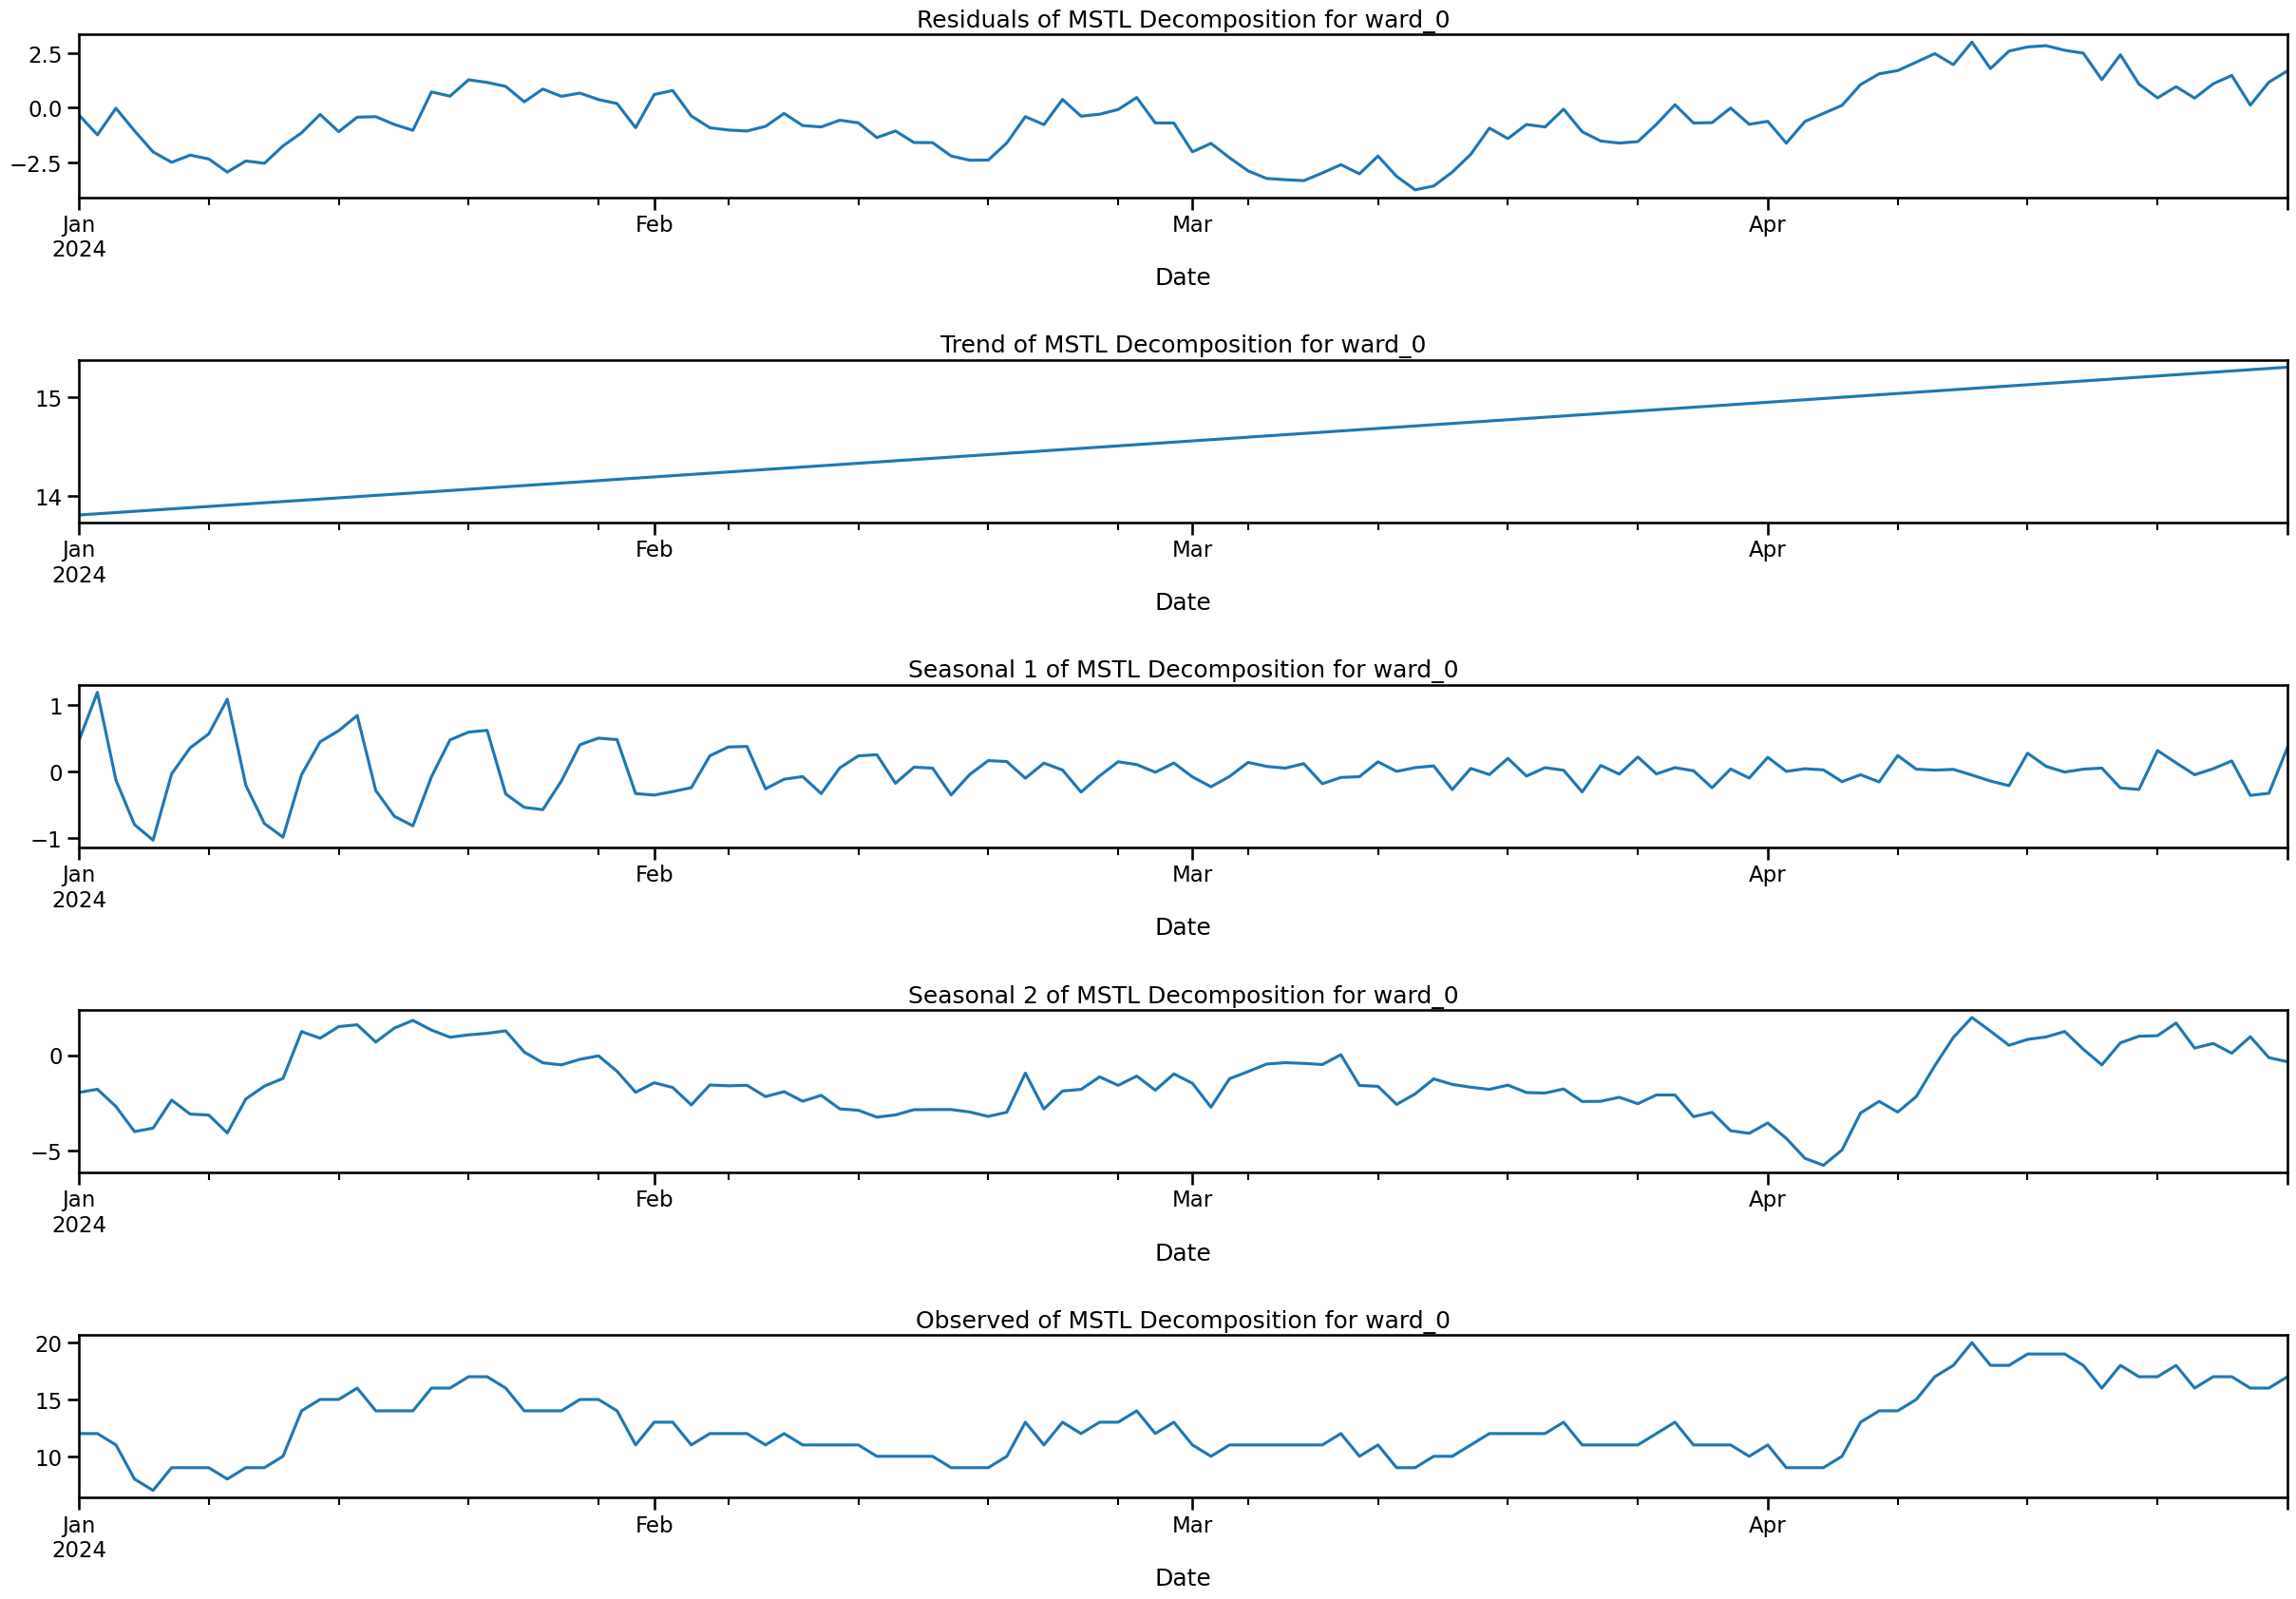

In [35]:
decomposition = MSTL(occup_train_clean["ward_1"], periods=[7, 365]).fit()  # 7=day, 365=year
fig, ax = plt.subplots(5, 1, figsize=(30, 20))
decomposition.resid['2024':].plot(title='Residuals of MSTL Decomposition for ward_0', ax=ax[0])
decomposition.trend['2024':].plot(title='Trend of MSTL Decomposition for ward_0', ax=ax[1])
decomposition.seasonal['2024':].iloc[:, 0].plot(title='Seasonal 1 of MSTL Decomposition for ward_0', ax=ax[2])
decomposition.seasonal['2024':].iloc[:, 1].plot(title='Seasonal 2 of MSTL Decomposition for ward_0', ax=ax[3])
decomposition.observed['2024':].plot(title='Observed of MSTL Decomposition for ward_0', ax=ax[4])
# increase distance between subplots
plt.subplots_adjust(hspace=1)
plt.show()